# Proyecto Final: Modelado de Bicicletas Públicas GCBA

## Objetivo
Predecir la cantidad de arribos de bicicletas que tendrá cada estación en un lapso de tiempo futuro (ΔT) basándose en:
- Cantidad de partidas de cada estación en un lapso de tiempo pasado (ΔT)
- Perfil de usuarios
- Características de las estaciones
- Features temporales

## Datos disponibles
- **Recorridos (trips)**: 2020-2024 (hasta agosto 2024)
- **Usuarios**: 2020-2024 con información demográfica y de bicicletas

## Estructura del problema
- **Input (X)**: Partidas de cada estación en ventana ΔT pasada + features
- **Output (Y)**: Arribos a cada estación en ventana ΔT futura


In [2]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuraciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librerías importadas correctamente")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")


Librerías importadas correctamente
Pandas version: 2.2.3
Numpy version: 2.2.6


## 1. Exploración inicial de los datos

Vamos a explorar primero los datasets para entender su estructura y características.


In [61]:
# Cargar el dataset unificado de todos los años (2020-2024)
print("=== CARGANDO DATASET UNIFICADO (2020-2024) ===")
df_trips_unificado = pd.read_csv('data/processed/trips_enriched.csv')

print(f"Shape del dataset completo: {df_trips_unificado.shape}")
print(f"Memoria utilizada: {df_trips_unificado.memory_usage(deep=True).sum() / (1024**3):.2f} GB")

print("\n=== ESTRUCTURA DEL DATASET UNIFICADO ===")
df_trips_unificado.drop(columns=['tiene_dni','hora_alta'], inplace=True)
print("Columnas disponibles:")
for i, col in enumerate(df_trips_unificado.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nPrimeras 5 filas:")
df_trips_unificado.head()


=== CARGANDO DATASET UNIFICADO (2020-2024) ===


C:\Users\Matteo\AppData\Local\Temp\ipykernel_31196\4282928035.py:3: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trips_unificado = pd.read_csv('data/processed/trips_enriched.csv')


Shape del dataset completo: (12976469, 21)
Memoria utilizada: 9.81 GB

=== ESTRUCTURA DEL DATASET UNIFICADO ===
Columnas disponibles:
 1. id_recorrido
 2. duracion_recorrido
 3. id_estacion_origen
 4. nombre_estacion_origen
 5. direccion_estacion_origen
 6. long_estacion_origen
 7. lat_estacion_origen
 8. id_estacion_destino
 9. nombre_estacion_destino
10. direccion_estacion_destino
11. long_estacion_destino
12. lat_estacion_destino
13. id_usuario
14. modelo_bicicleta
15. genero
16. fecha_origen_recorrido
17. fecha_destino_recorrido
18. edad_usuario
19. fecha_alta

Primeras 5 filas:


,id_recorrido,duracion_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,genero,fecha_origen_recorrido,fecha_destino_recorrido,edad_usuario,fecha_alta
0,7210548,1582,27,027 - Montevideo,Cordoba Av. & Montevideo,-58.390087,-34.599068,3.0,003 - ADUANA,Moreno & Av Paseo Colon,-58.368260,-34.61103,192009.0,ICONIC,FEMALE,2020-01-24 21:54:39,2020-01-24 22:21:01,NaN,NaN
1,7199093,204,151,151 - AIME PAINÉ,"Villaflor, Azucena & Paine, Aime",-58.361286,-34.611816,3.0,003 - ADUANA,Moreno & Av Paseo Colon,-58.368260,-34.61103,36380.0,ICONIC,MALE,2020-01-24 07:04:19,2020-01-24 07:07:43,NaN,NaN
2,7196805,1790,111,111 - MACACHA GUEMES,Machaca Guemes 350,-58.364685,-34.605488,3.0,003 - ADUANA,Moreno & Av Paseo Colon,-58.368260,-34.61103,460080.0,ICONIC,MALE,2020-01-24 00:15:17,2020-01-24 00:45:07,NaN,NaN
3,7203598,10688,285,400 - Reserva Ecologica,"Achaval Rodriguez, T., Dr. Av. 1520",-58.356174,-34.617210,4.0,004 - Plaza Roma,Lavalle & Bouchard,-58.368782,-34.60182,3857.0,ICONIC,MALE,2020-01-24 12:38:16,2020-01-24 15:36:24,NaN,NaN
4,7200335,673,171,171 - Pasteur,519 Pasteur,-58.399754,-34.603283,7.0,007 - OBELISCO,CARLOS PELEGRINI 215,-58.381100,-34.60650,391034.0,ICONIC,FEMALE,2020-01-24 08:31:01,2020-01-24 08:42:14,NaN,NaN


In [84]:
df_trips_sample = df_trips_unificado
print("=== INFORMACIÓN DETALLADA DEL DATASET DE TRIPS ===")
print(df_trips_sample.info())
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df_trips_sample.describe())


=== INFORMACIÓN DETALLADA DEL DATASET DE TRIPS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976469 entries, 0 to 12976468
Data columns (total 19 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   id_recorrido                int64  
 1   duracion_recorrido          int64  
 2   id_estacion_origen          int64  
 3   nombre_estacion_origen      object 
 4   direccion_estacion_origen   object 
 5   long_estacion_origen        float64
 6   lat_estacion_origen         float64
 7   id_estacion_destino         float64
 8   nombre_estacion_destino     object 
 9   direccion_estacion_destino  object 
 10  long_estacion_destino       float64
 11  lat_estacion_destino        float64
 12  id_usuario                  float64
 13  modelo_bicicleta            object 
 14  genero                      object 
 15  fecha_origen_recorrido      object 
 16  fecha_destino_recorrido     object 
 17  edad_usuario                object 
 18  fecha_alt

In [18]:
print("=== ESTRUCTURA DEL DATASET DE USUARIOS ===")
print(f"Shape de la muestra: {df_usuarios_sample.shape}")
print("\nColumnas:")
print(df_usuarios_sample.columns.tolist())
print("\nPrimeras 5 filas:")
df_usuarios_sample.head()


=== ESTRUCTURA DEL DATASET DE USUARIOS ===
Shape de la muestra: (197077, 5)

Columnas:
['id_usuario', 'genero_usuario', 'edad_usuario', 'fecha_alta', 'hora_alta']

Primeras 5 filas:


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,1094487,OTHER,35,2024-01-18,09:21:02
1,1097128,FEMALE,21,2024-01-21,23:02:26
2,1102901,OTHER,19,2024-01-29,19:33:32
3,1096100,FEMALE,29,2024-01-20,18:57:05
4,1103049,MALE,21,2024-01-30,00:49:33


In [19]:
print("=== INFORMACIÓN DETALLADA DEL DATASET DE USUARIOS ===")
print(df_usuarios_sample.info())
print("\n=== VALORES ÚNICOS EN COLUMNAS CATEGÓRICAS ===")
for col in df_usuarios_sample.select_dtypes(include=['object']).columns:
    print(f"\n{col}: {df_usuarios_sample[col].nunique()} valores únicos")
    print(f"Ejemplos: {df_usuarios_sample[col].unique()[:5]}")


=== INFORMACIÓN DETALLADA DEL DATASET DE USUARIOS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197077 entries, 0 to 197076
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id_usuario      197077 non-null  int64 
 1   genero_usuario  197077 non-null  object
 2   edad_usuario    197077 non-null  int64 
 3   fecha_alta      197077 non-null  object
 4   hora_alta       197077 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.5+ MB
None

=== VALORES ÚNICOS EN COLUMNAS CATEGÓRICAS ===

genero_usuario: 3 valores únicos
Ejemplos: ['OTHER' 'FEMALE' 'MALE']

fecha_alta: 366 valores únicos
Ejemplos: ['2024-01-18' '2024-01-21' '2024-01-29' '2024-01-20' '2024-01-30']

hora_alta: 64102 valores únicos
Ejemplos: ['09:21:02' '23:02:26' '19:33:32' '18:57:05' '00:49:33']


In [6]:
# 🔍 FUNCIÓN DE AUDITORÍA DE DATA LEAKAGE
def audit_data_leakage_sample(df_path, sample_size=10000):
    """
    Auditoría simplificada para detectar data leakage en muestra del dataset
    """
    print("=== 🔍 AUDITORÍA DE DATA LEAKAGE ===")
    
    # Cargar muestra pequeña
    print(f"Cargando muestra de {sample_size} registros...")
    df = pd.read_csv(df_path, nrows=sample_size)
    print(f"Muestra cargada: {df.shape}")
    
    # 1. VERIFICAR CORRELACIONES SOSPECHOSAS
    print("\n1. 📊 VERIFICANDO CORRELACIONES...")
    
    target = 'N_arribos_intervalo'
    lag_features = [col for col in df.columns if 'LAG' in col and 'ARRIBOS' in col]
    
    print(f"Target: {target}")
    print(f"LAG features encontradas: {lag_features}")
    
    correlations = {}
    if target in df.columns:
        for feature in lag_features:
            if feature in df.columns:
                corr = df[target].corr(df[feature])
                correlations[feature] = corr
        
        # Ordenar por correlación
        sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]) if not pd.isna(x[1]) else 0, reverse=True)
        
        print("   Correlaciones TARGET vs LAG features:")
        for feature, corr in sorted_corr[:10]:
            if not pd.isna(corr):
                status = "🚨 SOSPECHOSO" if abs(corr) > 0.8 else "✅ OK"
                print(f"   {feature}: {corr:.4f} {status}")
    
    # 2. VERIFICAR LÓGICA DE LAG TEMPORAL
    print("\n2. 🔄 VERIFICANDO LÓGICA DE LAG...")
    
    if 'fecha_intervalo' in df.columns:
        df['fecha_intervalo_dt'] = pd.to_datetime(df['fecha_intervalo'])
        
        if 'estacion_referencia' in df.columns and 'N_ARRIBOS_LAG1' in df.columns:
            # Tomar una estación con datos suficientes
            station_id = df['estacion_referencia'].value_counts().index[0]
            station_data = df[df['estacion_referencia'] == station_id].copy()
            station_data = station_data.sort_values('fecha_intervalo_dt').head(5)
            
            print(f"   Verificando estación {station_id}:")
            print("   Fecha_Intervalo | Target | LAG1 | LAG2")
            print("   " + "-"*50)
            
            for i, (idx, row) in enumerate(station_data.iterrows()):
                fecha = row['fecha_intervalo_dt']
                target_val = row.get('N_arribos_intervalo', 'N/A')
                lag1_val = row.get('N_ARRIBOS_LAG1', 'N/A')
                lag2_val = row.get('N_ARRIBOS_LAG2', 'N/A')
                
                print(f"   {fecha} | {target_val:4.0f} | {lag1_val:4.0f} | {lag2_val:4.0f}")
    
    # 3. DETECTAR FEATURES DEL FUTURO
    print("\n3. ⚠️  FEATURES DEL FUTURO DETECTADAS:")
    future_features = [col for col in df.columns if any(term in col.lower() 
                      for term in ['destino', 'arribo']) and 'LAG' not in col and col != target]
    
    if len(future_features) > 0:
        print(f"   Encontradas {len(future_features)} features potencialmente del futuro:")
        for f in future_features[:10]:
            print(f"     - {f}")
    else:
        print("   ✅ No se detectaron features obvias del futuro")
    
    return correlations, future_features

print("✅ Función de auditoría definida")


✅ Función de auditoría definida


In [7]:
# 🔍 EJECUTAR AUDITORÍA EN DATASET CON FEATURES ENGINEERED
try:
    # Verificar si existe el dataset con feature engineering
    correlations, future_features = audit_data_leakage_sample('data/processed/trips_features_engineered_fixed.csv')
    
    print(f"\n🎯 RESUMEN DE AUDITORÍA:")
    print(f"   - Features LAG analizadas: {len(correlations)}")
    print(f"   - Features del futuro detectadas: {len(future_features)}")
    
    # Verificar si hay correlaciones sospechosas
    high_corr = [f for f, c in correlations.items() if not pd.isna(c) and abs(c) > 0.8]
    if high_corr:
        print(f"   🚨 ALERTA: {len(high_corr)} features con correlación sospechosa")
        print(f"   Features sospechosas: {high_corr}")
    else:
        print(f"   ✅ No se detectaron correlaciones extremas")
        
except FileNotFoundError:
    print("⚠️ Archivo 'trips_features_engineered_fixed.csv' no encontrado")
    print("   Ejecutar primero el feature engineering antes de la auditoría")
except Exception as e:
    print(f"❌ Error en auditoría: {e}")
    
print("✅ Auditoría completada")


=== 🔍 AUDITORÍA DE DATA LEAKAGE ===
Cargando muestra de 10000 registros...
❌ Error en auditoría: name 'pd' is not defined
✅ Auditoría completada


In [8]:
# 🚀 CLASE PARA ENTRENAMIENTO SIN DATA LEAKAGE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class XGBoostBikePredictorNoLeakage:
    """
    Predictor XGBoost para bicicletas SIN DATA LEAKAGE
    """
    
    def __init__(self, use_gpu=True):
        self.use_gpu = use_gpu
        self.model = None
        self.training_features = None
        self.target = 'N_arribos_intervalo'
        
    def load_and_prepare_data(self, filepath, sample_size=50000):
        """Cargar y preparar datos sin leakage"""
        print(f"🛡️ Cargando muestra de {sample_size} registros...")
        df = pd.read_csv(filepath, nrows=sample_size)
        print(f"Dataset cargado: {df.shape}")
        
        # Convertir fecha para división temporal
        if 'fecha_intervalo' in df.columns:
            df['fecha_intervalo'] = pd.to_datetime(df['fecha_intervalo'])
        
        return df
    
    def select_safe_features(self, df):
        """Seleccionar solo features seguras (sin data leakage)"""
        print("Seleccionando features sin data leakage...")
        
        # Features seguras - información conocida ANTES del tiempo T
        safe_features = [
            # Features de usuario (conocidas antes del viaje)
            'id_usuario', 'modelo_bicicleta', 'genero_FEMALE', 'genero_MALE', 'genero_OTHER',
            'usuario_registrado', 'edad_usuario', 'año_alta', 'mes_alta',
            
            # Features de origen (conocidas al inicio)
            'id_estacion_origen', 'barrio_origen', 'zona_origen_cluster', 
            'cantidad_estaciones_cercanas_origen',
            
            # Features temporales del origen
            'año_origen', 'mes_origen', 'dia_origen', 'hora_origen', 'minuto_origen',
            'dia_semana', 'es_finde', 'estacion_del_anio',
            
            # Features de destino PLANIFICADO (no futuro real)
            'barrio_destino', 'zona_destino_cluster', 'cantidad_estaciones_cercanas_destino',
            
            # Features de ventana temporal (estructura temporal)
            'año_intervalo', 'mes_intervalo', 'dia_intervalo', 'hora_intervalo', 'minuto_intervalo',
            
            # LAGs históricos (información del PASADO)
            'N_ARRIBOS_LAG1', 'N_SALIDAS_LAG1', 'N_ARRIBOS_LAG2', 'N_SALIDAS_LAG2',
            'N_ARRIBOS_LAG3', 'N_SALIDAS_LAG3', 'N_ARRIBOS_LAG4', 'N_SALIDAS_LAG4',
            'N_ARRIBOS_LAG5', 'N_SALIDAS_LAG5', 'N_ARRIBOS_LAG6', 'N_SALIDAS_LAG6',
            'N_ARRIBOS_PROM_2INT', 'N_SALIDAS_PROM_2INT'
        ]
        
        # Filtrar features que realmente existen
        available_features = [col for col in safe_features if col in df.columns]
        missing_features = [col for col in safe_features if col not in df.columns]
        
        print(f"Features disponibles: {len(available_features)}")
        if len(missing_features) > 0:
            print(f"Features faltantes: {len(missing_features)}")
        
        # Asegurar tipos numéricos
        for col in available_features:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        
        self.training_features = available_features
        return available_features
    
    def temporal_split(self, df):
        """División temporal correcta para evitar data leakage"""
        print("Realizando división temporal...")
        
        if 'fecha_intervalo' not in df.columns:
            print("⚠️ División aleatoria (no temporal)")
            return train_test_split(df, test_size=0.2, random_state=42)
        
        # Ordenar por fecha y dividir temporalmente
        df = df.sort_values('fecha_intervalo').reset_index(drop=True)
        split_idx = int(len(df) * 0.8)
        
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        
        print(f"Train: {len(train_df)} registros ({train_df['fecha_intervalo'].min()} - {train_df['fecha_intervalo'].max()})")
        print(f"Test: {len(test_df)} registros ({test_df['fecha_intervalo'].min()} - {test_df['fecha_intervalo'].max()})")
        
        return train_df, test_df
    
    def audit_correlations(self, X_train, y_train):
        """Auditar correlaciones antes del entrenamiento"""
        print("\n🔍 AUDITORÍA DE CORRELACIONES:")
        
        correlations = {}
        for feature in X_train.columns:
            corr = y_train.corr(X_train[feature])
            if not pd.isna(corr):
                correlations[feature] = abs(corr)
        
        # Top 5 correlaciones
        sorted_corr = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
        
        print("Top 5 correlaciones con target:")
        suspicious_features = []
        
        for i, (feature, corr) in enumerate(sorted_corr[:5]):
            status = ""
            if corr > 0.9:
                status = "🚨 EXTREMA"
                suspicious_features.append(feature)
            elif corr > 0.8:
                status = "⚠️  ALTA"
            elif corr > 0.5:
                status = "🔶 MEDIA"
            else:
                status = "✅ OK"
            
            print(f"  {i+1}. {feature:<25} {corr:.3f} {status}")
        
        if suspicious_features:
            print(f"\n⚠️ Features sospechosas: {suspicious_features}")
        
        return correlations
    
    def train_and_evaluate(self, df, sample_size=50000):
        """Pipeline completo de entrenamiento y evaluación"""
        print("=== 🎯 ENTRENAMIENTO SIN DATA LEAKAGE ===")
        
        # 1. Cargar datos
        if isinstance(df, str):
            df = self.load_and_prepare_data(df, sample_size)
        
        # 2. Seleccionar features seguras
        feature_cols = self.select_safe_features(df)
        
        if len(feature_cols) == 0:
            print("❌ No se encontraron features válidas")
            return None
        
        # 3. División temporal
        train_df, test_df = self.temporal_split(df)
        
        # 4. Preparar X, y
        X_train = train_df[feature_cols]
        y_train = train_df[self.target]
        X_test = test_df[feature_cols]
        y_test = test_df[self.target]
        
        print(f"Train shape: {X_train.shape}")
        print(f"Test shape: {X_test.shape}")
        
        # 5. Auditar correlaciones
        correlations = self.audit_correlations(X_train, y_train)
        
        # 6. Entrenar modelo XGBoost
        print("\n🚀 Entrenando XGBoost...")
        
        params = {
            'objective': 'reg:squarederror',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 200,  # Reducido para notebook
            'random_state': 42,
            'n_jobs': -1
        }
        
        self.model = xgb.XGBRegressor(**params)
        self.model.fit(X_train, y_train, verbose=False)
        
        # 7. Evaluar
        y_pred = self.model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\n📊 MÉTRICAS DEL MODELO:")
        print(f"MAE:  {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R²:   {r2:.4f}")
        
        # Interpretación de métricas
        if r2 > 0.95:
            print("🚨 ¡ALERTA! R² extremadamente alto - posible data leakage")
        elif r2 > 0.8:
            print("⚠️  R² alto - verificar overfitting")
        elif r2 > 0.5:
            print("✅ R² razonable para predicción temporal")
        else:
            print("🔶 R² bajo - considerar más features")
        
        # Feature importance
        importance = self.model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        print(f"\n📈 TOP 5 FEATURES MÁS IMPORTANTES:")
        for i, (_, row) in enumerate(importance_df.head(5).iterrows()):
            print(f"  {i+1}. {row['feature']:<25} {row['importance']:.4f}")
        
        # Verificar dominancia de una feature
        top_importance = importance_df.iloc[0]['importance']
        if top_importance > 0.5:
            print(f"🚨 Feature dominante: {importance_df.iloc[0]['feature']} ({top_importance:.3f})")
        
        return {
            'model': self.model,
            'metrics': {'mae': mae, 'rmse': rmse, 'r2': r2},
            'importance': importance_df,
            'correlations': correlations,
            'feature_count': len(feature_cols)
        }

print("✅ Clase XGBoostBikePredictorNoLeakage definida")


✅ Clase XGBoostBikePredictorNoLeakage definida


In [9]:
# 🎯 ENTRENAMIENTO Y COMPARACIÓN DE MODELOS
try:
    # Crear predictor sin data leakage
    predictor_no_leakage = XGBoostBikePredictorNoLeakage()
    
    # Entrenar modelo sin data leakage
    print("=" * 60)
    print("🛡️ MODELO SIN DATA LEAKAGE")
    print("=" * 60)
    
    results_no_leakage = predictor_no_leakage.train_and_evaluate(
        'data/processed/trips_features_engineered_fixed.csv', 
        sample_size=50000
    )
    
    if results_no_leakage:
        print("\n" + "=" * 60)
        print("📊 RESUMEN DE RESULTADOS")
        print("=" * 60)
        
        print(f"🛡️ MODELO SIN DATA LEAKAGE:")
        print(f"   R²: {results_no_leakage['metrics']['r2']:.4f}")
        print(f"   RMSE: {results_no_leakage['metrics']['rmse']:.4f}")
        print(f"   Features usadas: {results_no_leakage['feature_count']}")
        
        # Mostrar feature más importante
        top_feature = results_no_leakage['importance'].iloc[0]
        print(f"   Feature más importante: {top_feature['feature']} ({top_feature['importance']:.3f})")
        
        print(f"\n✅ CONCLUSIÓN:")
        r2_no_leakage = results_no_leakage['metrics']['r2']
        
        if r2_no_leakage > 0.95:
            print("🚨 POSIBLE DATA LEAKAGE DETECTADO - R² extremadamente alto")
        elif r2_no_leakage > 0.7:
            print("✅ MODELO REALISTA - R² apropiado para predicción temporal")
        elif r2_no_leakage > 0.5:
            print("✅ MODELO ACEPTABLE - R² moderado pero válido")
        else:
            print("⚠️ MODELO DÉBIL - Considerar más features o mejor feature engineering")
            
        print(f"\n🎯 INTERPRETACIÓN:")
        print(f"   - R² = {r2_no_leakage:.3f} indica que el modelo explica {r2_no_leakage*100:.1f}% de la varianza")
        print(f"   - Este es un nivel realista para predicción de arribos de bicicletas")
        print(f"   - La autocorrelación temporal es natural en series de tiempo")
        
    else:
        print("❌ Error en el entrenamiento del modelo sin data leakage")
        
except FileNotFoundError:
    print("⚠️ Archivo no encontrado. Verificar que el feature engineering esté completo.")
except Exception as e:
    print(f"❌ Error en entrenamiento: {e}")
    
print("\n✅ Análisis de data leakage completado")


🛡️ MODELO SIN DATA LEAKAGE
=== 🎯 ENTRENAMIENTO SIN DATA LEAKAGE ===
🛡️ Cargando muestra de 50000 registros...
❌ Error en entrenamiento: name 'pd' is not defined

✅ Análisis de data leakage completado


## 2. Análisis de las fechas y filtrado hasta Agosto 2024

Necesitamos asegurarnos de que solo usemos datos hasta agosto 2024 inclusive, como indica el enunciado.


In [10]:
# Función para analizar las columnas de fecha en trips
def analizar_fechas_trips(df):
    # Buscar columnas que contengan información de fecha/tiempo
    date_cols = [col for col in df.columns if any(keyword in col.lower() 
                for keyword in ['fecha', 'date', 'inicio', 'fin', 'start', 'end', 'time', 'hora'])]
    
    print("Columnas relacionadas con fechas/tiempo:")
    for col in date_cols:
        print(f"- {col}")
        if df[col].dtype == 'object':
            print(f"  Ejemplos: {df[col].dropna().head(3).tolist()}")
        print()
    
    return date_cols

print("=== ANÁLISIS DE FECHAS EN TRIPS ===")
date_columns = analizar_fechas_trips(df_trips_sample)


=== ANÁLISIS DE FECHAS EN TRIPS ===


NameError: name 'df_trips_sample' is not defined

## 3. Función para cargar y preparar datos

Vamos a crear funciones para cargar los datos de manera eficiente y hacer el preprocesamiento inicial.


In [86]:
def cargar_datos_trips(años, hasta_agosto_2024=True):
    """
    Carga los datos de trips de los años especificados.
    Si hasta_agosto_2024=True, filtra los datos de 2024 hasta agosto inclusive.
    """
    dfs = []
    
    for año in años:
        print(f"Cargando datos de {año}...")
        df = pd.read_csv(f'data/raw/trips_{año}.csv')
        
        # Si es 2024, filtrar hasta agosto
        if año == 2024 and hasta_agosto_2024:
            # Primero identificar la columna de fecha de inicio
            # Esto lo haremos después de ver la estructura real
            pass
        
        df['año'] = año
        dfs.append(df)
        print(f"  - {len(df):,} registros cargados")
    
    df_completo = pd.concat(dfs, ignore_index=True)
    print(f"\nTotal de registros cargados: {len(df_completo):,}")
    
    return df_completo

def cargar_datos_usuarios(años):
    """
    Carga los datos de usuarios de los años especificados.
    """
    dfs = []
    
    for año in años:
        print(f"Cargando usuarios de {año}...")
        df = pd.read_csv(f'data/raw/usuarios_ecobici_{año}.csv')
        df['año_registro'] = año
        dfs.append(df)
        print(f"  - {len(df):,} usuarios cargados")
    
    df_usuarios = pd.concat(dfs, ignore_index=True)
    print(f"\nTotal de usuarios cargados: {len(df_usuarios):,}")
    
    return df_usuarios

# Por ahora solo vamos a cargar una muestra de 2024 para entender la estructura
print("Cargando muestra de datos 2024 para análisis...")


Cargando muestra de datos 2024 para análisis...


In [87]:
# Cargar una muestra más grande para análisis detallado (primeros 50k registros)
df_trips_2024 = df_trips_sample

print("=== ANÁLISIS DETALLADO DE COLUMNAS DE FECHA ===")
print(f"Shape: {df_trips_2024.shape}")
print(f"Columnas: {df_trips_2024.columns.tolist()}")

# Analizar columnas que parezcan de fecha/tiempo
for col in df_trips_2024.columns:
    if df_trips_2024[col].dtype == 'object':
        sample_vals = df_trips_2024[col].dropna().head(5).tolist()
        # Verificar si algún valor parece una fecha
        if any(any(char in str(val) for char in ['-', '/', ':', ' ']) for val in sample_vals):
            print(f"\n{col}:")
            print(f"  Ejemplos: {sample_vals}")
            print(f"  Tipo: {df_trips_2024[col].dtype}")
            print(f"  Nulos: {df_trips_2024[col].isnull().sum()}")


=== ANÁLISIS DETALLADO DE COLUMNAS DE FECHA ===
Shape: (12976469, 19)
Columnas: ['id_recorrido', 'duracion_recorrido', 'id_estacion_origen', 'nombre_estacion_origen', 'direccion_estacion_origen', 'long_estacion_origen', 'lat_estacion_origen', 'id_estacion_destino', 'nombre_estacion_destino', 'direccion_estacion_destino', 'long_estacion_destino', 'lat_estacion_destino', 'id_usuario', 'modelo_bicicleta', 'genero', 'fecha_origen_recorrido', 'fecha_destino_recorrido', 'edad_usuario', 'fecha_alta']

nombre_estacion_origen:
  Ejemplos: ['027 - Montevideo', '151 - AIME PAINÉ', '111 - MACACHA GUEMES', '400 - Reserva Ecologica', '171 - Pasteur']
  Tipo: object
  Nulos: 0

direccion_estacion_origen:
  Ejemplos: ['Cordoba Av. & Montevideo', 'Villaflor, Azucena & Paine, Aime', 'Machaca Guemes 350', 'Achaval Rodriguez, T., Dr. Av. 1520', '519 Pasteur']
  Tipo: object
  Nulos: 0

nombre_estacion_destino:
  Ejemplos: ['003 - ADUANA', '003 - ADUANA', '003 - ADUANA', '004 - Plaza Roma', '007 - OBELISCO

## 4. Análisis de estaciones

Vamos a analizar las estaciones de origen y destino para entender la estructura espacial de la red de bicicletas.


In [88]:
# Análisis de estaciones
print("=== ANÁLISIS DE ESTACIONES ===")

# Identificar columnas de estaciones
station_cols = [col for col in df_trips_2024.columns if any(keyword in col.lower() 
               for keyword in ['estacion', 'station', 'origen', 'destino', 'origin', 'destination'])]

print("Columnas relacionadas con estaciones:")
for col in station_cols:
    print(f"- {col}")
    if df_trips_2024[col].dtype in ['object', 'int64', 'float64']:
        print(f"  Valores únicos: {df_trips_2024[col].nunique()}")
        print(f"  Ejemplos: {df_trips_2024[col].dropna().unique()[:5]}")
    print()
# Análisis básico de estaciones
print("\n=== ESTADÍSTICAS BÁSICAS DE ESTACIONES ===")
for col in station_cols:
    if 'id' in col.lower() or 'numero' in col.lower():
        print(f"\n{col}:")
        numeric_series = pd.to_numeric(df_trips_2024[col], errors='coerce')  # Fuerza conversión a numérico
        print(f"  Min: {numeric_series.min()}")
        print(f"  Max: {numeric_series.max()}")
        print(f"  Valores únicos: {df_trips_2024[col].nunique()}")
        print(f"  Nulos: {df_trips_2024[col].isnull().sum()}")






=== ANÁLISIS DE ESTACIONES ===
Columnas relacionadas con estaciones:
- id_estacion_origen
  Valores únicos: 501
  Ejemplos: [ 27 151 111 285 171]

- nombre_estacion_origen
  Valores únicos: 510
  Ejemplos: ['027 - Montevideo' '151 - AIME PAINÉ' '111 - MACACHA GUEMES'
 '400 - Reserva Ecologica' '171 - Pasteur']

- direccion_estacion_origen
  Valores únicos: 556
  Ejemplos: ['Cordoba Av. & Montevideo' 'Villaflor, Azucena & Paine, Aime'
 'Machaca Guemes 350' 'Achaval Rodriguez, T., Dr. Av. 1520' '519 Pasteur']

- long_estacion_origen
  Valores únicos: 544
  Ejemplos: [-58.390087 -58.361286 -58.364685 -58.356174 -58.399754]

- lat_estacion_origen
  Valores únicos: 543
  Ejemplos: [-34.599068 -34.611816 -34.605488 -34.61721  -34.603283]

- id_estacion_destino
  Valores únicos: 501
  Ejemplos: [ 3.  4.  7. 13. 14.]

- nombre_estacion_destino
  Valores únicos: 511
  Ejemplos: ['003 - ADUANA' '004 - Plaza Roma' '007 - OBELISCO' '013 - ONCE'
 '014 - Pacifico']

- direccion_estacion_destino
  Va

## 5. Definición de la estrategia de preprocesamiento

Basándonos en el análisis inicial, vamos a definir nuestra estrategia para crear las ventanas de tiempo ΔT y estructurar los datos para el modelo.


In [89]:
# Estrategia de preprocesamiento

print("=== ESTRATEGIA DE PREPROCESAMIENTO ===")
print("""
1. VENTANA DE TIEMPO (ΔT):
   - Proponemos usar ΔT = 30 minutos
   - Input: Partidas en los últimos 30 minutos
   - Output: Arribos en los próximos 30 minutos

2. GRANULARIDAD TEMPORAL:
   - Dividir cada día en ventanas de 30 minutos
   - 48 ventanas por día (00:00-00:30, 00:30-01:00, ..., 23:30-24:00)

3. FEATURES A INCLUIR:
   - Temporales: hora, día semana, mes, festivos
   - Estaciones: ubicación (lat/lng), barrio, capacidad
   - Usuarios: perfil demográfico agregado por ventana
   - Históricas: patrones de demanda por estación

4. ESTRUCTURA DE DATOS:
   - Cada fila = una ventana de tiempo T para todas las estaciones
   - X: features de partidas en ventana [T-30min, T]
   - Y: arribos reales en ventana [T, T+30min]
""")

# Parámetros del modelo
DELTA_T_MINUTES = 30  # Ventana de tiempo en minutos
SAMPLING_FREQ = '30T'  # Frecuencia de muestreo (30 minutos)

print(f"Configuración elegida:")
print(f"- ΔT = {DELTA_T_MINUTES} minutos")
print(f"- Frecuencia de muestreo: {SAMPLING_FREQ}")


=== ESTRATEGIA DE PREPROCESAMIENTO ===

1. VENTANA DE TIEMPO (ΔT):
   - Proponemos usar ΔT = 30 minutos
   - Input: Partidas en los últimos 30 minutos
   - Output: Arribos en los próximos 30 minutos

2. GRANULARIDAD TEMPORAL:
   - Dividir cada día en ventanas de 30 minutos
   - 48 ventanas por día (00:00-00:30, 00:30-01:00, ..., 23:30-24:00)

3. FEATURES A INCLUIR:
   - Temporales: hora, día semana, mes, festivos
   - Estaciones: ubicación (lat/lng), barrio, capacidad
   - Usuarios: perfil demográfico agregado por ventana
   - Históricas: patrones de demanda por estación

4. ESTRUCTURA DE DATOS:
   - Cada fila = una ventana de tiempo T para todas las estaciones
   - X: features de partidas en ventana [T-30min, T]
   - Y: arribos reales en ventana [T, T+30min]

Configuración elegida:
- ΔT = 30 minutos
- Frecuencia de muestreo: 30T


## 6. Análisis de fechas y filtrado hasta Agosto 2024

Basándonos en el análisis inicial, ahora vamos a:
1. Convertir las fechas a formato datetime
2. Filtrar los datos hasta agosto 2024 inclusive
3. Analizar la distribución temporal de los datos


In [90]:
# Función para procesar fechas y filtrar hasta agosto 2024
def procesar_fechas_y_filtrar(df, hasta_agosto_2024=True,desde_agosto_2020=True):
    """
    Convierte las fechas a datetime y filtra hasta agosto 2024 si se especifica
    """
    df = df.copy()
    
    # Convertir fechas a datetime
    df['fecha_origen_dt'] = pd.to_datetime(df['fecha_origen_recorrido'])
    df['fecha_destino_dt'] = pd.to_datetime(df['fecha_destino_recorrido'])
    
    # Extraer componentes temporales útiles de la fecha origen
    df['año'] = df['fecha_origen_dt'].dt.year
    df['mes'] = df['fecha_origen_dt'].dt.month
    df['dia'] = df['fecha_origen_dt'].dt.day
    df['dia_semana'] = df['fecha_origen_dt'].dt.dayofweek  # 0=Lunes, 6=Domingo
    df['hora'] = df['fecha_origen_dt'].dt.hour
    df['minuto'] = df['fecha_origen_dt'].dt.minute
    
    print(f"Fecha mínima: {df['fecha_origen_dt'].min()}")
    print(f"Fecha máxima: {df['fecha_origen_dt'].max()}")
    if desde_agosto_2020:
        antes_filtro = len(df)
        fecha_minima = pd.Timestamp('2020-08-01 00:00:00')
        df = df[df['fecha_origen_dt'] >= fecha_minima]
        despues_filtro = len(df)
        print(f"\\nRegistros eliminados antes de agosto 2020: {antes_filtro - despues_filtro:,}")
        print(f"Registros restantes: {despues_filtro:,}")
        print(f"Nueva fecha mínima: {df['fecha_origen_dt'].min()}")

    # Filtrar hasta agosto 2024 inclusive si es necesario
    if hasta_agosto_2024:
        antes_filtro = len(df)
        fecha_limite = pd.Timestamp('2024-08-31 23:59:59')
        df = df[df['fecha_origen_dt'] <= fecha_limite]
        despues_filtro = len(df)
        print(f"\\nRegistros eliminados después de agosto 2024: {antes_filtro - despues_filtro:,}")
        print(f"Registros restantes: {despues_filtro:,}")
        print(f"Nueva fecha máxima: {df['fecha_origen_dt'].max()}")
    
    return df

# Procesar una muestra para verificar
print("=== PROCESAMIENTO DE FECHAS ===")
df_sample_procesado = procesar_fechas_y_filtrar(df_trips_2024)

=== PROCESAMIENTO DE FECHAS ===
Fecha mínima: 2020-01-01 00:00:08
Fecha máxima: 2024-08-31 23:54:32
\nRegistros eliminados antes de agosto 2020: 928,136
Registros restantes: 12,048,333
Nueva fecha mínima: 2020-08-01 00:01:25
\nRegistros eliminados después de agosto 2024: 0
Registros restantes: 12,048,333
Nueva fecha máxima: 2024-08-31 23:54:32


In [91]:
# Análisis de distribución temporal
print("=== DISTRIBUCIÓN TEMPORAL ===")
print(f"Distribución por mes:")
print(df_sample_procesado.groupby('mes').size().sort_index())

print(f"\\nDistribución por día de la semana (0=Lunes, 6=Domingo):")
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
dist_dias = df_sample_procesado.groupby('dia_semana').size()
for i, dia in enumerate(dias_semana):
    if i in dist_dias.index:
        print(f"{dia}: {dist_dias[i]}")

print(f"\\nDistribución por hora del día:")
print(df_sample_procesado.groupby('hora').size().sort_index())


=== DISTRIBUCIÓN TEMPORAL ===
Distribución por mes:
mes
1     1002928
2     1028794
3     1135150
4      985546
5      881889
6      778914
7      762588
8     1203627
9     1011303
10    1101434
11    1155068
12    1001092
dtype: int64
\nDistribución por día de la semana (0=Lunes, 6=Domingo):
Lunes: 1957898
Martes: 2089977
Miércoles: 2080638
Jueves: 2093322
Viernes: 1966837
Sábado: 940432
Domingo: 919229
\nDistribución por hora del día:
hora
0      220341
1      151500
2       85783
3       49610
4       44817
5       99148
6      206299
7      417914
8      549879
9      502093
10     461293
11     535137
12     661034
13     725230
14     732741
15     824822
16     978753
17    1100608
18    1080118
19     839194
20     692308
21     493089
22     337375
23     259247
dtype: int64


## 7. Creación de ventanas temporales y agregación de datos

Ahora vamos a implementar la lógica principal para crear las ventanas de 30 minutos y agregar los datos por estación.


In [92]:
def crear_ventanas_temporales(df, delta_t_minutes=30):
    """
    Crea ventanas temporales de delta_t_minutes y agrega partidas/arribos por estación
    """
    df = df.copy()
    
    # Crear ventanas temporales redondeando hacia abajo a los delta_t_minutes más cercanos
    df['ventana_origen'] = df['fecha_origen_dt'].dt.floor(f'{delta_t_minutes}T')
    df['ventana_destino'] = df['fecha_destino_dt'].dt.floor(f'{delta_t_minutes}T')
    
    print(f"Ventanas creadas con intervalos de {delta_t_minutes} minutos")
    print(f"Ejemplo de ventana origen: {df['ventana_origen'].iloc[0]}")
    print(f"Primera ventana: {df['ventana_origen'].min()}")
    print(f"Última ventana: {df['ventana_origen'].max()}")
    
    return df

# Crear ventanas en la muestra
print("=== CREACIÓN DE VENTANAS TEMPORALES ===")
df_con_ventanas = crear_ventanas_temporales(df_sample_procesado, DELTA_T_MINUTES)


=== CREACIÓN DE VENTANAS TEMPORALES ===
Ventanas creadas con intervalos de 30 minutos
Ejemplo de ventana origen: 2020-08-20 13:00:00
Primera ventana: 2020-08-01 00:00:00
Última ventana: 2024-08-31 23:30:00


In [93]:
def agregar_partidas_arribos(df):
    """
    Agrega partidas y arribos por estación y ventana temporal
    """
    
    # Agregar PARTIDAS: cuántas bicicletas salen de cada estación en cada ventana
    partidas = df.groupby(['ventana_origen', 'id_estacion_origen']).agg({
        'id_recorrido': 'count',  # número de partidas
        'genero': lambda x: (x == 'MALE').sum(),  # partidas de hombres
        'modelo_bicicleta': lambda x: (x == 'FIT').sum(),  # partidas con bici FIT
        'id_usuario': 'nunique'  # usuarios únicos que partieron
    }).rename(columns={
        'id_recorrido': 'num_partidas',
        'genero': 'partidas_male',
        'modelo_bicicleta': 'partidas_fit',
        'id_usuario': 'usuarios_unicos_partidas'
    }).reset_index()
    
    # Agregar ARRIBOS: cuántas bicicletas llegan a cada estación en cada ventana  
    arribos = df.dropna(subset=['ventana_destino']).groupby(['ventana_destino', 'id_estacion_destino']).agg({
        'id_recorrido': 'count',  # número de arribos
        'genero': lambda x: (x == 'MALE').sum(),  # arribos de hombres
        'modelo_bicicleta': lambda x: (x == 'FIT').sum(),  # arribos con bici FIT
        'id_usuario': 'nunique'
    }).rename(columns={
        'id_recorrido': 'num_arribos',
        'genero': 'arribos_male', 
        'modelo_bicicleta': 'arribos_fit',
        'id_usuario': 'usuarios_unicos_arribos'
    }).reset_index()
    
    print(f"Partidas agregadas: {len(partidas):,} registros")
    print(f"Arribos agregados: {len(arribos):,} registros")
    
    return partidas, arribos

# Agregar datos en la muestra
print("=== AGREGACIÓN DE PARTIDAS Y ARRIBOS ===")
partidas_sample, arribos_sample = agregar_partidas_arribos(df_con_ventanas)


=== AGREGACIÓN DE PARTIDAS Y ARRIBOS ===
Partidas agregadas: 6,388,599 registros
Arribos agregados: 6,544,499 registros


In [94]:
# Verificar los resultados de la agregación
print("=== VERIFICACIÓN DE AGREGACIÓN ===")
print("\\nPartidas (primeras 5 filas):")
print(partidas_sample.head())

print("\\nEstadísticas de partidas:")
print(partidas_sample['num_partidas'].describe())

print("\\nArribos (primeras 5 filas):")
print(arribos_sample.head())

print("\\nEstadísticas de arribos:")
print(arribos_sample['num_arribos'].describe())


=== VERIFICACIÓN DE AGREGACIÓN ===
\nPartidas (primeras 5 filas):
  ventana_origen  id_estacion_origen  num_partidas  partidas_male  \
0     2020-08-01                   5             4              4   
1     2020-08-01                   9             1              0   
2     2020-08-01                  33             1              0   
3     2020-08-01                  58             2              1   
4     2020-08-01                  69             1              0   

   partidas_fit  usuarios_unicos_partidas  
0             0                         4  
1             0                         1  
2             0                         1  
3             0                         2  
4             0                         1  
\nEstadísticas de partidas:
count    6.388599e+06
mean     1.885912e+00
std      1.411236e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.900000e+01
Name: num_partidas, dtype: float64
\nArribos (prime

## 8. Creación de la estructura de datos para el modelo

Ahora vamos a crear la estructura donde cada fila representa un punto en el tiempo T, con:
- **X**: Features de partidas en ventana [T-30min, T] 
- **Y**: Arribos reales en ventana [T, T+30min]


In [95]:
def crear_dataset_modelo(partidas, arribos, delta_t_minutes=30):
    """
    Crea el dataset final para entrenar el modelo.
    Cada fila representa una ventana temporal T donde:
    - X: partidas en [T-delta_t, T]
    - Y: arribos en [T, T+delta_t]
    """
    
    # Obtener todas las combinaciones de ventanas y estaciones
    # Convertir a Series antes de concatenar
    ventanas_partidas = pd.Series(partidas['ventana_origen'].unique())
    ventanas_arribos = pd.Series(arribos['ventana_destino'].unique())
    todas_ventanas = pd.concat([ventanas_partidas, ventanas_arribos])
    todas_ventanas = todas_ventanas.drop_duplicates().sort_values().reset_index(drop=True)
    
    estaciones_partidas = pd.Series(partidas['id_estacion_origen'].unique())
    estaciones_arribos = pd.Series(arribos['id_estacion_destino'].unique())
    todas_estaciones = pd.concat([estaciones_partidas, estaciones_arribos])
    todas_estaciones = todas_estaciones.drop_duplicates().sort_values().reset_index(drop=True)
    
    print(f"Ventanas temporales únicas: {len(todas_ventanas)}")
    print(f"Estaciones únicas: {len(todas_estaciones)}")
    print(f"Rango temporal: {todas_ventanas.min()} a {todas_ventanas.max()}")
    
    # Crear grid completo de ventanas x estaciones
    grid = pd.MultiIndex.from_product([
        todas_ventanas,
        todas_estaciones
    ], names=['ventana', 'id_estacion']).to_frame(index=False)
    
    print(f"Grid inicial: {len(grid):,} combinaciones ventana-estación")
    
    return grid, todas_ventanas, todas_estaciones

# Crear estructura base del dataset
print("=== CREACIÓN DE ESTRUCTURA BASE ===")
grid_base, ventanas_unicas, estaciones_unicas = crear_dataset_modelo(partidas_sample, arribos_sample)


=== CREACIÓN DE ESTRUCTURA BASE ===
Ventanas temporales únicas: 71546
Estaciones únicas: 398
Rango temporal: 2020-08-01 00:00:00 a 2024-09-14 16:30:00
Grid inicial: 28,475,308 combinaciones ventana-estación


In [96]:
# Crear estructura base del dataset
print("=== CREACIÓN DE ESTRUCTURA BASE ===")
grid_base, ventanas_unicas, estaciones_unicas = crear_dataset_modelo(partidas_sample, arribos_sample)


=== CREACIÓN DE ESTRUCTURA BASE ===
Ventanas temporales únicas: 71546
Estaciones únicas: 398
Rango temporal: 2020-08-01 00:00:00 a 2024-09-14 16:30:00
Grid inicial: 28,475,308 combinaciones ventana-estación


In [97]:
def construir_features_y_targets(grid, partidas, arribos, delta_t_minutes=30):
    """
    Construye las features (X) y targets (Y) para cada punto temporal
    """
    delta_t = pd.Timedelta(minutes=delta_t_minutes)
    
    # Agregar partidas (Features X) para cada ventana
    partidas_pivot = partidas.rename(columns={
        'ventana_origen': 'ventana',
        'id_estacion_origen': 'id_estacion'
    })
    
    grid_con_partidas = grid.merge(
        partidas_pivot,
        on=['ventana', 'id_estacion'],
        how='left'
    ).fillna(0)
    
    # Agregar arribos (Target Y) para la ventana SIGUIENTE
    grid_con_partidas['ventana_siguiente'] = grid_con_partidas['ventana'] + delta_t
    
    arribos_pivot = arribos.rename(columns={
        'ventana_destino': 'ventana_siguiente',
        'id_estacion_destino': 'id_estacion'
    })
    
    dataset_completo = grid_con_partidas.merge(
        arribos_pivot,
        on=['ventana_siguiente', 'id_estacion'],
        how='left',
        suffixes=('', '_target')
    ).fillna(0)
    
    # Limpiar y renombrar columnas
    dataset_completo = dataset_completo.drop('ventana_siguiente', axis=1)
    
    print(f"Dataset final: {len(dataset_completo):,} filas")
    print(f"Columnas: {dataset_completo.columns.tolist()}")
    
    return dataset_completo

# Construir dataset con features y targets
print("=== CONSTRUCCIÓN DE FEATURES Y TARGETS ===")
dataset_final = construir_features_y_targets(grid_base, partidas_sample, arribos_sample)


=== CONSTRUCCIÓN DE FEATURES Y TARGETS ===
Dataset final: 28,475,308 filas
Columnas: ['ventana', 'id_estacion', 'num_partidas', 'partidas_male', 'partidas_fit', 'usuarios_unicos_partidas', 'num_arribos', 'arribos_male', 'arribos_fit', 'usuarios_unicos_arribos']


In [98]:
# Verificar el dataset final
print("=== VERIFICACIÓN DEL DATASET FINAL ===")
print("\\nPrimeras 10 filas:")
print(dataset_final.head(10))

print("\\nInformación general:")
print(dataset_final.info())

print("\\nEstadísticas de las variables target:")
target_cols = [col for col in dataset_final.columns if 'arribos' in col or 'target' in col]
print(f"Columnas target identificadas: {target_cols}")
if target_cols:
    print(dataset_final[target_cols].describe())


=== VERIFICACIÓN DEL DATASET FINAL ===
\nPrimeras 10 filas:
     ventana  id_estacion  num_partidas  partidas_male  partidas_fit  \
0 2020-08-01          2.0           0.0            0.0           0.0   
1 2020-08-01          3.0           0.0            0.0           0.0   
2 2020-08-01          4.0           0.0            0.0           0.0   
3 2020-08-01          5.0           4.0            4.0           0.0   
4 2020-08-01          6.0           0.0            0.0           0.0   
5 2020-08-01          7.0           0.0            0.0           0.0   
6 2020-08-01          8.0           0.0            0.0           0.0   
7 2020-08-01          9.0           1.0            0.0           0.0   
8 2020-08-01         12.0           0.0            0.0           0.0   
9 2020-08-01         13.0           0.0            0.0           0.0   

   usuarios_unicos_partidas  num_arribos  arribos_male  arribos_fit  \
0                       0.0          0.0           0.0          0.0   
1    

## 9. Agregado de features adicionales

Vamos a enriquecer el dataset con features temporales y de estaciones que pueden ser útiles para el modelo.


In [99]:
def agregar_features_temporales(dataset):
    """
    Agrega features temporales derivadas de la ventana de tiempo
    """
    dataset = dataset.copy()
    
    # Features temporales
    dataset['year'] = dataset['ventana'].dt.year
    dataset['hora'] = dataset['ventana'].dt.hour
    dataset['dia_semana'] = dataset['ventana'].dt.dayofweek  # 0=Lunes, 6=Domingo
    dataset['mes'] = dataset['ventana'].dt.month
    dataset['dia_mes'] = dataset['ventana'].dt.day
    
    # Features cíclicas para capturar patrones periódicos
    dataset['hora_sin'] = np.sin(2 * np.pi * dataset['hora'] / 24)
    dataset['hora_cos'] = np.cos(2 * np.pi * dataset['hora'] / 24)
    dataset['dia_semana_sin'] = np.sin(2 * np.pi * dataset['dia_semana'] / 7)
    dataset['dia_semana_cos'] = np.cos(2 * np.pi * dataset['dia_semana'] / 7)
    
    # Indicadores categóricos
    dataset['es_fin_semana'] = (dataset['dia_semana'] >= 5).astype(int)  # Sábado y Domingo
    dataset['es_hora_pico_mañana'] = ((dataset['hora'] >= 7) & (dataset['hora'] <= 9)).astype(int)
    dataset['es_hora_pico_tarde'] = ((dataset['hora'] >= 17) & (dataset['hora'] <= 19)).astype(int)
    dataset['es_horario_laboral'] = ((dataset['hora'] >= 8) & (dataset['hora'] <= 18)).astype(int)
    
    print(f"Features temporales agregadas: {['hora', 'dia_semana', 'mes', 'dia_mes', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'es_fin_semana', 'es_hora_pico_mañana', 'es_hora_pico_tarde', 'es_horario_laboral']}")
    
    return dataset

def agregar_features_estaciones(dataset, df_original):
    """
    Agrega información geográfica y características de las estaciones
    """
    dataset = dataset.copy()
    
    # Obtener información única de cada estación del dataset original
    info_estaciones = df_original.groupby('id_estacion_origen').agg({
        'long_estacion_origen': 'first',
        'lat_estacion_origen': 'first',
        'nombre_estacion_origen': 'first',
        'direccion_estacion_origen': 'first'
    }).reset_index()
    
    info_estaciones.columns = ['id_estacion', 'longitud', 'latitud', 'nombre_estacion', 'direccion_estacion']
    
    # Merge con el dataset
    dataset = dataset.merge(info_estaciones, on='id_estacion', how='left')
    
    print(f"Features de estaciones agregadas: {['longitud', 'latitud', 'nombre_estacion', 'direccion_estacion']}")
    print(f"Estaciones con información geográfica: {dataset['longitud'].notna().sum()} de {len(dataset)}\")")
    
    return dataset

# Agregar features al dataset
print("=== AGREGANDO FEATURES ADICIONALES ===")
dataset_enriched = agregar_features_temporales(dataset_final)
dataset_enriched = agregar_features_estaciones(dataset_enriched, df_con_ventanas)


=== AGREGANDO FEATURES ADICIONALES ===
Features temporales agregadas: ['hora', 'dia_semana', 'mes', 'dia_mes', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'es_fin_semana', 'es_hora_pico_mañana', 'es_hora_pico_tarde', 'es_horario_laboral']
Features de estaciones agregadas: ['longitud', 'latitud', 'nombre_estacion', 'direccion_estacion']
Estaciones con información geográfica: 28117578 de 28475308")


In [100]:
# Verificar el dataset enriquecido
print("=== DATASET ENRIQUECIDO ===")
print(f"\\nShape final: {dataset_enriched.shape}")
print(f"\\nColumnas disponibles:")
for i, col in enumerate(dataset_enriched.columns):
    print(f"{i+1:2d}. {col}")

print(f"\\nPrimeras 3 filas del dataset enriquecido:")
print(dataset_enriched.head(3))


=== DATASET ENRIQUECIDO ===
\nShape final: (28475308, 27)
\nColumnas disponibles:
 1. ventana
 2. id_estacion
 3. num_partidas
 4. partidas_male
 5. partidas_fit
 6. usuarios_unicos_partidas
 7. num_arribos
 8. arribos_male
 9. arribos_fit
10. usuarios_unicos_arribos
11. year
12. hora
13. dia_semana
14. mes
15. dia_mes
16. hora_sin
17. hora_cos
18. dia_semana_sin
19. dia_semana_cos
20. es_fin_semana
21. es_hora_pico_mañana
22. es_hora_pico_tarde
23. es_horario_laboral
24. longitud
25. latitud
26. nombre_estacion
27. direccion_estacion
\nPrimeras 3 filas del dataset enriquecido:
     ventana  id_estacion  num_partidas  partidas_male  partidas_fit  \
0 2020-08-01          2.0           0.0            0.0           0.0   
1 2020-08-01          3.0           0.0            0.0           0.0   
2 2020-08-01          4.0           0.0            0.0           0.0   

   usuarios_unicos_partidas  num_arribos  arribos_male  arribos_fit  \
0                       0.0          0.0           0.0 

## 10. Función integrada para procesar todos los datos

Ahora vamos a crear una función que integre todo el pipeline de preprocesamiento para poder aplicarlo a todos los años de datos.


In [44]:
def pipeline_preprocesamiento_completo(años, delta_t_minutes=30, hasta_agosto_2024=True, guardar_procesado=True):
    """
    Pipeline completo de preprocesamiento para crear el dataset del modelo
    """
    print(f"=== INICIANDO PIPELINE COMPLETO ===")
    print(f"Años a procesar: {años}")
    print(f"Delta T: {delta_t_minutes} minutos")
    print(f"Filtrar hasta agosto 2024: {hasta_agosto_2024}")
    
    all_datasets = []
    
    for año in años:
        print(f"\\n--- PROCESANDO AÑO {año} ---")
        
        # 1. Cargar datos del año
        df_año = pd.read_csv(f'data/raw/trips_{año}.csv')
        print(f"Cargados {len(df_año):,} registros de {año}")
        
        # 2. Procesar fechas y filtrar
        df_procesado = procesar_fechas_y_filtrar(df_año, hasta_agosto_2024=(año==2024 and hasta_agosto_2024))
        
        # 3. Crear ventanas temporales
        df_con_ventanas = crear_ventanas_temporales(df_procesado, delta_t_minutes)
        
        # 4. Agregar partidas y arribos
        partidas, arribos = agregar_partidas_arribos(df_con_ventanas)
        
        # 5. Crear estructura del dataset
        grid, _, _ = crear_dataset_modelo(partidas, arribos, delta_t_minutes)
        dataset = construir_features_y_targets(grid, partidas, arribos, delta_t_minutes)
        
        # 6. Agregar features adicionales
        dataset = agregar_features_temporales(dataset)
        dataset = agregar_features_estaciones(dataset, df_con_ventanas)
        
        # 7. Agregar año como feature
        dataset['año'] = año
        
        all_datasets.append(dataset)
        print(f"Dataset de {año} completado: {len(dataset):,} filas")
        
        # Liberar memoria
        del df_año, df_procesado, df_con_ventanas, partidas, arribos, grid
    
    # Combinar todos los años
    print(f"\\n=== COMBINANDO DATASETS ===")
    dataset_completo = pd.concat(all_datasets, ignore_index=True)
    print(f"Dataset final combinado: {len(dataset_completo):,} filas, {len(dataset_completo.columns)} columnas")
    
    # Guardar si se especifica
    if guardar_procesado:
        output_path = 'data/processed/dataset_bicis_modelo.csv'
        dataset_completo.to_csv(output_path, index=False)
        print(f"Dataset guardado en: {output_path}")
    
    return dataset_completo

# Por ahora vamos a probar con solo 2024 para validar el pipeline
print("PRUEBA DEL PIPELINE CON UN AÑO:")

dataset_procesado = pipeline_preprocesamiento_completo(años=[2024], delta_t_minutes=30, hasta_agosto_2024=True, guardar_procesado=True)


PRUEBA DEL PIPELINE CON UN AÑO:
=== INICIANDO PIPELINE COMPLETO ===
Años a procesar: [2024]
Delta T: 30 minutos
Filtrar hasta agosto 2024: True
\n--- PROCESANDO AÑO 2024 ---
Cargados 3,559,284 registros de 2024
Fecha mínima: 2024-01-01 00:06:50
Fecha máxima: 2024-12-31 23:58:25
\nRegistros eliminados después de agosto 2024: 1,403,639
Registros restantes: 2,155,645
Nueva fecha máxima: 2024-08-31 23:54:32


C:\Users\Matteo\AppData\Local\Temp\ipykernel_31196\81400743.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['ventana_origen'] = df['fecha_origen_dt'].dt.floor(f'{delta_t_minutes}T')
C:\Users\Matteo\AppData\Local\Temp\ipykernel_31196\81400743.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['ventana_destino'] = df['fecha_destino_dt'].dt.floor(f'{delta_t_minutes}T')


Ventanas creadas con intervalos de 30 minutos
Ejemplo de ventana origen: 2024-01-23 18:30:00
Primera ventana: 2024-01-01 00:00:00
Última ventana: 2024-08-31 23:30:00


KeyboardInterrupt: 

## 11. Resumen del preprocesamiento y próximos pasos

### ¿Qué hemos logrado hasta ahora?

1. **Análisis exploratorio completo** de la estructura de datos
2. **Pipeline de preprocesamiento** que:
   - Filtra datos hasta agosto 2024
   - Crea ventanas de tiempo de 30 minutos  
   - Agrega partidas y arribos por estación/ventana
   - Estructura datos como X (partidas en T-30min) → Y (arribos en T+30min)
   - Agrega features temporales, geográficas y de usuario

3. **Dataset estructurado** donde cada fila representa:
   - **Input (X)**: Partidas de todas las estaciones en una ventana de 30min
   - **Output (Y)**: Arribos a todas las estaciones en la siguiente ventana de 30min

### Estructura final del dataset:
- **Features temporales**: hora, día semana, mes, indicadores de horarios pico
- **Features de estaciones**: ubicación geográfica, ID 
- **Features de partidas**: cantidad de partidas, por género, por tipo de bici
- **Target**: cantidad de arribos en ventana siguiente

### Próximos pasos:
1. **Ejecutar pipeline completo** con todos los años (2020-2024)
2. **Análisis exploratorio** del dataset final
3. **División train/validation/test** temporal
4. **Selección y entrenamiento de modelos**


In [101]:
# guardar el dataset enriquecido en un csv
dataset_enriched.to_csv('data/processed/dataset_bicis_modelo.csv', index=False)

# mostrar las primeras filas del dataset enriquecido
print(dataset_enriched.head())




     ventana  id_estacion  num_partidas  partidas_male  partidas_fit  \
0 2020-08-01          2.0           0.0            0.0           0.0   
1 2020-08-01          3.0           0.0            0.0           0.0   
2 2020-08-01          4.0           0.0            0.0           0.0   
3 2020-08-01          5.0           4.0            4.0           0.0   
4 2020-08-01          6.0           0.0            0.0           0.0   

   usuarios_unicos_partidas  num_arribos  arribos_male  arribos_fit  \
0                       0.0          0.0           0.0          0.0   
1                       0.0          0.0           0.0          0.0   
2                       0.0          0.0           0.0          0.0   
3                       4.0          0.0           0.0          0.0   
4                       0.0          0.0           0.0          0.0   

   usuarios_unicos_arribos  year  hora  dia_semana  mes  dia_mes  hora_sin  \
0                      0.0  2020     0           5    8       

# Modelo Baseline

Ahora que tenemos nuestro dataset preprocesado, vamos a implementar un modelo baseline para establecer una línea base de performance.

## Estrategia del modelo baseline:
1. **Modelo simple pero efectivo**: Empezaremos con Random Forest que es robusto
2. **División temporal**: Train (enero-junio), Validation (julio), Test (agosto)
3. **Features principales**: Partidas + features temporales + geográficas
4. **Métricas**: MAE, RMSE, R² para evaluar predicción de arribos


In [3]:
#abrir csv
dataset_enriched = pd.read_csv('data/processed/dataset_bicis_modelo.csv')

In [4]:
# Importar librerías para el modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings('ignore')

dataset_procesado = dataset_enriched
print("Librerías para modelos importadas correctamente")
print(f"Tamaño del dataset: {dataset_procesado.shape}")
print(f"Memoria ocupada: {dataset_procesado.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


Librerías para modelos importadas correctamente
Tamaño del dataset: (28475308, 27)
Memoria ocupada: 11659.8 MB


In [5]:
## 1. Análisis rápido del dataset y preparación


# Verificar las columnas disponibles
print("=== COLUMNAS DISPONIBLES ===")
print("Columnas del dataset:")
for i, col in enumerate(dataset_procesado.columns):
    print(f"{i+1:2d}. {col}")

print(f"\nForma del dataset: {dataset_procesado.shape}")

# Verificar distribución de la variable objetivo
print("\n=== ANÁLISIS DE LA VARIABLE OBJETIVO (num_arribos) ===")
print(dataset_procesado['num_arribos'].describe())

# Ver distribución temporal
print("\n=== DISTRIBUCIÓN TEMPORAL ===")
print("Rango de fechas:")
print(f"Desde: {dataset_procesado['ventana'].min()}")
print(f"Hasta: {dataset_procesado['ventana'].max()}")

# Verificar valores nulos
print("\n=== VALORES NULOS ===")
nulos = dataset_procesado.isnull().sum()
print("Columnas con valores nulos:")
print(nulos[nulos > 0])


=== COLUMNAS DISPONIBLES ===
Columnas del dataset:
 1. ventana
 2. id_estacion
 3. num_partidas
 4. partidas_male
 5. partidas_fit
 6. usuarios_unicos_partidas
 7. num_arribos
 8. arribos_male
 9. arribos_fit
10. usuarios_unicos_arribos
11. year
12. hora
13. dia_semana
14. mes
15. dia_mes
16. hora_sin
17. hora_cos
18. dia_semana_sin
19. dia_semana_cos
20. es_fin_semana
21. es_hora_pico_mañana
22. es_hora_pico_tarde
23. es_horario_laboral
24. longitud
25. latitud
26. nombre_estacion
27. direccion_estacion

Forma del dataset: (28475308, 27)

=== ANÁLISIS DE LA VARIABLE OBJETIVO (num_arribos) ===
count    2.847531e+07
mean     4.231099e-01
std      1.008866e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.600000e+01
Name: num_arribos, dtype: float64

=== DISTRIBUCIÓN TEMPORAL ===
Rango de fechas:
Desde: 2020-08-01 00:00:00
Hasta: 2024-09-14 16:30:00

=== VALORES NULOS ===
Columnas con valores nulos:
longitud              357730
latitud

In [6]:
## 2. División temporal del dataset

# Convertir la columna ventana a datetime si no lo está ya
dataset_procesado['ventana'] = pd.to_datetime(dataset_procesado['ventana'])

# Definir las divisiones temporales
fecha_split_train_val = '2024-08-31'
fecha_split_val_test = '2024-08-31'

# Crear máscaras para cada conjunto
mask_train = dataset_procesado['ventana'] < fecha_split_train_val
mask_val = (dataset_procesado['ventana'] >= fecha_split_train_val) & (dataset_procesado['ventana'] < fecha_split_val_test)
mask_test = dataset_procesado['ventana'] >= fecha_split_val_test

# Dividir el dataset
train_data = dataset_procesado[mask_train].copy()
val_data = dataset_procesado[mask_val].copy()
test_data = dataset_procesado[mask_test].copy()

print("=== DIVISIÓN TEMPORAL DEL DATASET ===")
print(f"Train (enero-junio): {len(train_data):,} registros ({len(train_data)/len(dataset_procesado)*100:.1f}%)")
print(f"  Desde: {train_data['ventana'].min()}")
print(f"  Hasta: {train_data['ventana'].max()}")

print(f"\\nValidation (julio): {len(val_data):,} registros ({len(val_data)/len(dataset_procesado)*100:.1f}%)")
print(f"  Desde: {val_data['ventana'].min()}")
print(f"  Hasta: {val_data['ventana'].max()}")

print(f"\\nTest (agosto): {len(test_data):,} registros ({len(test_data)/len(dataset_procesado)*100:.1f}%)")
print(f"  Desde: {test_data['ventana'].min()}")
print(f"  Hasta: {test_data['ventana'].max()}")

# Verificar distribución de la variable objetivo en cada conjunto
print("\\n=== DISTRIBUCIÓN DE ARRIBOS POR CONJUNTO ===")
print("Train:")
print(train_data['num_arribos'].describe())
print("\\nValidation:")
print(val_data['num_arribos'].describe())
print("\\nTest:")
print(test_data['num_arribos'].describe())


=== DIVISIÓN TEMPORAL DEL DATASET ===
Train (enero-junio): 28,453,418 registros (99.9%)
  Desde: 2020-08-01 00:00:00
  Hasta: 2024-08-30 23:30:00
\nValidation (julio): 0 registros (0.0%)
  Desde: NaT
  Hasta: NaT
\nTest (agosto): 21,890 registros (0.1%)
  Desde: 2024-08-31 00:00:00
  Hasta: 2024-09-14 16:30:00
\n=== DISTRIBUCIÓN DE ARRIBOS POR CONJUNTO ===
Train:
count    2.845342e+07
mean     4.234209e-01
std      1.009183e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.600000e+01
Name: num_arribos, dtype: float64
\nValidation:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: num_arribos, dtype: float64
\nTest:
count    21890.000000
mean         0.018821
std          0.149961
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: num_arribos, dtype: float64


In [7]:
# === DIVISIÓN ESTRATÉGICA DEL DATASET ===

def crear_division_dias_aleatorios(dataset, dias_val_por_mes=3, dias_test_por_mes=2, random_seed=42):
    """
    Crea división train/val/test seleccionando días aleatorios de cada mes
    
    Args:
        dataset: DataFrame con columna 'ventana'
        dias_val_por_mes: Número de días aleatorios por mes para validation
        dias_test_por_mes: Número de días aleatorios por mes para test
        random_seed: Semilla para reproducibilidad
    
    Returns:
        máscaras train, val, test
    """
    print("=== CREANDO DIVISIÓN POR DÍAS ALEATORIOS ===")
    np.random.seed(random_seed)
    
    # Crear columnas auxiliares para agrupación
    dataset_temp = dataset.copy()
    dataset_temp['fecha'] = dataset_temp['ventana'].dt.date
    dataset_temp['año_mes'] = dataset_temp['ventana'].dt.to_period('M')
    
    # Inicializar máscaras
    mask_val = pd.Series(False, index=dataset.index)
    mask_test = pd.Series(False, index=dataset.index)
    
    # Para cada mes, seleccionar días aleatorios
    meses_disponibles = dataset_temp['año_mes'].unique()
    print(f"Procesando {len(meses_disponibles)} meses...")
    
    resumen_por_mes = []
    
    for mes in sorted(meses_disponibles):
        # Obtener todos los días únicos del mes
        dias_del_mes = dataset_temp[dataset_temp['año_mes'] == mes]['fecha'].unique()
        total_dias = len(dias_del_mes)
        
        if total_dias < (dias_val_por_mes + dias_test_por_mes):
            print(f"   ⚠️ {mes}: Solo {total_dias} días disponibles, ajustando...")
            dias_val_actual = min(dias_val_por_mes, total_dias // 2)
            dias_test_actual = min(dias_test_por_mes, total_dias - dias_val_actual)
        else:
            dias_val_actual = dias_val_por_mes
            dias_test_actual = dias_test_por_mes
        
        # Seleccionar días aleatorios
        dias_seleccionados = np.random.choice(dias_del_mes, 
                                            size=dias_val_actual + dias_test_actual, 
                                            replace=False)
        
        dias_val_mes = dias_seleccionados[:dias_val_actual]
        dias_test_mes = dias_seleccionados[dias_val_actual:dias_val_actual + dias_test_actual]
        
        # Aplicar máscaras
        for dia in dias_val_mes:
            mask_val |= (dataset_temp['fecha'] == dia)
            
        for dia in dias_test_mes:
            mask_test |= (dataset_temp['fecha'] == dia)
        
        # Guardar resumen
        dias_train_actual = total_dias - dias_val_actual - dias_test_actual
        resumen_por_mes.append({
            'mes': str(mes),
            'total_dias': total_dias,
            'train': dias_train_actual,
            'val': dias_val_actual,
            'test': dias_test_actual
        })
    
    # Crear máscara de train (todo lo que no es val ni test)
    mask_train = ~(mask_val | mask_test)
    
    # Mostrar resumen
    print(f"\\n=== RESUMEN DE DIVISIÓN POR MES ===")
    print("Mes          | Total | Train | Val | Test")
    print("-" * 40)
    for resumen in resumen_por_mes[:6]:  # Mostrar primeros 6 meses
        print(f"{resumen['mes']:12} |   {resumen['total_dias']:2d}  |   {resumen['train']:2d}  |  {resumen['val']:2d}  |  {resumen['test']:2d}")
    
    if len(resumen_por_mes) > 6:
        print(f"... y {len(resumen_por_mes) - 6} meses más")
    
    return mask_train, mask_val, mask_test, resumen_por_mes

# Aplicar la división estratégica
print("\\n" + "="*60)
print("DIVISIÓN ESTRATÉGICA DEL DATASET")
print("="*60)

# Convertir ventana a datetime si no lo está
dataset_procesado['ventana'] = pd.to_datetime(dataset_procesado['ventana'])

# Crear división por días aleatorios
mask_train, mask_val, mask_test, resumen_division = crear_division_dias_aleatorios(
    dataset_procesado,
    dias_val_por_mes=3,    # 3 días aleatorios por mes para validation
    dias_test_por_mes=1,   # 2 días aleatorios por mes para test  
    random_seed=42
)

# Aplicar máscaras
train_data = dataset_procesado[mask_train].copy()
val_data = dataset_procesado[mask_val].copy()
test_data = dataset_procesado[mask_test].copy()

print(f"\\n=== RESULTADO DE LA DIVISIÓN ===")
print(f"Train: {len(train_data):,} registros ({len(train_data)/len(dataset_procesado)*100:.1f}%)")
print(f"  Período: {train_data['ventana'].min()} a {train_data['ventana'].max()}")
print(f"  Meses únicos: {train_data['ventana'].dt.to_period('M').nunique()}")

print(f"\\nValidation: {len(val_data):,} registros ({len(val_data)/len(dataset_procesado)*100:.1f}%)")
print(f"  Período: {val_data['ventana'].min()} a {val_data['ventana'].max()}")
print(f"  Días únicos: {val_data['ventana'].dt.date.nunique()}")

print(f"\\nTest: {len(test_data):,} registros ({len(test_data)/len(dataset_procesado)*100:.1f}%)")
print(f"  Período: {test_data['ventana'].min()} a {test_data['ventana'].max()}")
print(f"  Días únicos: {test_data['ventana'].dt.date.nunique()}")

# Verificar distribución de la variable objetivo
print(f"\\n=== DISTRIBUCIÓN DE ARRIBOS POR CONJUNTO ===")
for nombre, datos in [("Train", train_data), ("Validation", val_data), ("Test", test_data)]:
    stats = datos['num_arribos'].describe()
    print(f"\\n{nombre}:")
    print(f"  Media: {stats['mean']:.3f} | Mediana: {stats['50%']:.1f} | Max: {stats['max']:.0f}")
    print(f"  % zeros: {(datos['num_arribos'] == 0).mean()*100:.1f}%")
    print(f"  % con actividad: {(datos['num_arribos'] > 0).mean()*100:.1f}%")


\n============================================================
DIVISIÓN ESTRATÉGICA DEL DATASET
=== CREANDO DIVISIÓN POR DÍAS ALEATORIOS ===
Procesando 50 meses...
   ⚠️ 2024-09: Solo 3 días disponibles, ajustando...
\n=== RESUMEN DE DIVISIÓN POR MES ===
Mes          | Total | Train | Val | Test
----------------------------------------
2020-08      |   31  |   27  |   3  |   1
2020-09      |   30  |   26  |   3  |   1
2020-10      |   31  |   27  |   3  |   1
2020-11      |   30  |   26  |   3  |   1
2020-12      |   31  |   27  |   3  |   1
2021-01      |   31  |   27  |   3  |   1
... y 44 meses más
\n=== RESULTADO DE LA DIVISIÓN ===
Train: 24,731,322 registros (86.9%)
  Período: 2020-08-01 00:00:00 a 2024-09-01 16:30:00
  Meses únicos: 50
\nValidation: 2,808,288 registros (9.9%)
  Período: 2020-08-16 00:00:00 a 2024-09-03 01:00:00
  Días únicos: 148
\nTest: 935,698 registros (3.3%)
  Período: 2020-08-18 00:00:00 a 2024-09-14 16:30:00
  Días únicos: 50
\n=== DISTRIBUCIÓN DE ARRIBOS P

In [8]:
# === VERIFICACIÓN DETALLADA DE LA DIVISIÓN ===

def verificar_division_temporal(train_data, val_data, test_data):
    """
    Verifica que la división temporal sea balanceada y representativa
    """
    print("=== VERIFICACIÓN DE DIVISIÓN TEMPORAL ===")
    
    # 1. Distribución por año
    print("\\n1. DISTRIBUCIÓN POR AÑO:")
    años_disponibles = sorted(train_data['year'].unique())
    
    for año in años_disponibles:
        train_año = len(train_data[train_data['year'] == año])
        val_año = len(val_data[val_data['year'] == año])
        test_año = len(test_data[test_data['year'] == año])
        total_año = train_año + val_año + test_año
        
        print(f"   {año}: Train {train_año:,} ({train_año/total_año*100:.1f}%) | "
              f"Val {val_año:,} ({val_año/total_año*100:.1f}%) | "
              f"Test {test_año:,} ({test_año/total_año*100:.1f}%)")
    
    # 2. Verificar solapamiento (no debería haber)
    fechas_train = set(train_data['ventana'].dt.date)
    fechas_val = set(val_data['ventana'].dt.date)
    fechas_test = set(test_data['ventana'].dt.date)
    
    solapamiento_train_val = len(fechas_train & fechas_val)
    solapamiento_train_test = len(fechas_train & fechas_test)
    solapamiento_val_test = len(fechas_val & fechas_test)
    
    print(f"\\n2. VERIFICACIÓN DE SOLAPAMIENTO:")
    print(f"   Train-Val: {solapamiento_train_val} días solapados")
    print(f"   Train-Test: {solapamiento_train_test} días solapados")
    print(f"   Val-Test: {solapamiento_val_test} días solapados")
    
    if solapamiento_train_val + solapamiento_train_test + solapamiento_val_test == 0:
        print("   ✅ Sin solapamiento - División correcta")
    else:
        print("   ⚠️ Hay solapamiento - Revisar división")
    
    # 3. Resumen de representatividad
    print(f"\\n3. RESUMEN DE REPRESENTATIVIDAD:")
    print(f"   Días únicos por conjunto:")
    print(f"     Train: {train_data['ventana'].dt.date.nunique()} días")
    print(f"     Val:   {val_data['ventana'].dt.date.nunique()} días") 
    print(f"     Test:  {test_data['ventana'].dt.date.nunique()} días")

# Ejecutar verificación
verificar_division_temporal(train_data, val_data, test_data)

print(f"\\n=== 🎯 DIVISIÓN COMPLETADA EXITOSAMENTE ===")
print(f"✅ Método: 3 días aleatorios/mes para validation, 2 para test")
print(f"✅ Seed: 42 (reproducible)")
print(f"✅ Sin solapamiento entre conjuntos")
print(f"✅ Distribución temporal balanceada")
print(f"\\n🎯 El dataset está listo para entrenamiento con división robusta")


=== VERIFICACIÓN DE DIVISIÓN TEMPORAL ===
\n1. DISTRIBUCIÓN POR AÑO:
   2020: Train 2,539,240 (86.9%) | Val 286,560 (9.8%) | Test 95,520 (3.3%)
   2021: Train 6,044,824 (86.8%) | Val 687,346 (9.9%) | Test 228,452 (3.3%)
   2022: Train 6,054,376 (86.8%) | Val 687,744 (9.9%) | Test 229,248 (3.3%)
   2023: Train 6,055,172 (86.8%) | Val 687,744 (9.9%) | Test 229,248 (3.3%)
   2024: Train 4,037,710 (86.8%) | Val 458,894 (9.9%) | Test 153,230 (3.3%)
\n2. VERIFICACIÓN DE SOLAPAMIENTO:
   Train-Val: 0 días solapados
   Train-Test: 0 días solapados
   Val-Test: 0 días solapados
   ✅ Sin solapamiento - División correcta
\n3. RESUMEN DE REPRESENTATIVIDAD:
   Días únicos por conjunto:
     Train: 1297 días
     Val:   148 días
     Test:  50 días
\n=== 🎯 DIVISIÓN COMPLETADA EXITOSAMENTE ===
✅ Método: 3 días aleatorios/mes para validation, 2 para test
✅ Seed: 42 (reproducible)
✅ Sin solapamiento entre conjuntos
✅ Distribución temporal balanceada
\n🎯 El dataset está listo para entrenamiento con divi

In [9]:
## 3. Selección de features y preparación de datos
# Definir las columnas de features que vamos a usar para el modelo baseline
features_partidas = ['num_partidas', 'partidas_male', 'partidas_fit', 'usuarios_unicos_partidas']
features_temporales = ['hora', 'dia_semana', 'mes', 'dia_mes', 'hora_sin', 'hora_cos', 
                      'dia_semana_sin', 'dia_semana_cos', 'es_fin_semana', 
                      'es_hora_pico_mañana', 'es_hora_pico_tarde', 'es_horario_laboral']
features_geograficas = ['longitud', 'latitud', 'id_estacion']
features_adicionales = ['year']

# Combinar todas las features numéricas
features_numericas = features_partidas + features_temporales + features_geograficas + features_adicionales

print("=== FEATURES SELECCIONADAS PARA EL MODELO BASELINE ===")
print(f"Features de partidas ({len(features_partidas)}): {features_partidas}")
print(f"Features temporales ({len(features_temporales)}): {features_temporales}")
print(f"Features geográficas ({len(features_geograficas)}): {features_geograficas}")
print(f"Features adicionales ({len(features_adicionales)}): {features_adicionales}")
print(f"\\nTotal features: {len(features_numericas)}")

# Variable objetivo
target = 'num_arribos'

# Preparar X e y para cada conjunto
def preparar_datos(data, features, target):
    X = data[features].copy()
    y = data[target].copy()
    
    # Limpiar datos si hay valores nulos
    mask_validos = ~(X.isnull().any(axis=1) | y.isnull())
    X_clean = X[mask_validos]
    y_clean = y[mask_validos]
    
    return X_clean, y_clean

X_train, y_train = preparar_datos(train_data, features_numericas, target)
X_val, y_val = preparar_datos(val_data, features_numericas, target)
X_test, y_test = preparar_datos(test_data, features_numericas, target)

print("\\n=== TAMAÑOS DE DATASETS DESPUÉS DE LIMPIEZA ===")
print(f"Train: X={X_train.shape}, y={len(y_train)}")
print(f"Val:   X={X_val.shape}, y={len(y_val)}")
print(f"Test:  X={X_test.shape}, y={len(y_test)}")

# Verificar si hay features con varianza cero
print("\\n=== VERIFICACIÓN DE FEATURES ===")
varianzas = X_train.var()
features_cero_varianza = varianzas[varianzas == 0].index.tolist()
if features_cero_varianza:
    print(f"Features con varianza cero: {features_cero_varianza}")
else:
    print("Todas las features tienen varianza > 0")

print(f"\\nRango de valores en y_train: {y_train.min():.1f} - {y_train.max():.1f}")
print(f"Media de arribos en train: {y_train.mean():.2f}")
print(f"Std de arribos en train: {y_train.std():.2f}")


=== FEATURES SELECCIONADAS PARA EL MODELO BASELINE ===
Features de partidas (4): ['num_partidas', 'partidas_male', 'partidas_fit', 'usuarios_unicos_partidas']
Features temporales (12): ['hora', 'dia_semana', 'mes', 'dia_mes', 'hora_sin', 'hora_cos', 'dia_semana_sin', 'dia_semana_cos', 'es_fin_semana', 'es_hora_pico_mañana', 'es_hora_pico_tarde', 'es_horario_laboral']
Features geográficas (3): ['longitud', 'latitud', 'id_estacion']
Features adicionales (1): ['year']
\nTotal features: 20
\n=== TAMAÑOS DE DATASETS DESPUÉS DE LIMPIEZA ===
Train: X=(24420627, 20), y=24420627
Val:   X=(2773008, 20), y=2773008
Test:  X=(923943, 20), y=923943
\n=== VERIFICACIÓN DE FEATURES ===
Todas las features tienen varianza > 0
\nRango de valores en y_train: 0.0 - 36.0
Media de arribos en train: 0.43
Std de arribos en train: 1.01


In [55]:
## 4. Entrenamiento del modelo baseline
from sklearn.ensemble import RandomForestRegressor
# Para empezar con algo rápido, vamos a usar una muestra del dataset de entrenamiento
# ya que tenemos 2.7M de registros que pueden ser lentos para un primer modelo

print("=== CONFIGURACIÓN DEL MODELO BASELINE ===")

# Tomar una muestra representativa para entrenamiento rápido
sample_size = 10000000  # 100k registros para empezar
if len(X_train) > sample_size:
    # Hacer un sampling estratificado por hora para mantener distribución temporal
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_train), size=sample_size, replace=False)
    X_train_sample = X_train.iloc[sample_indices]
    y_train_sample = y_train.iloc[sample_indices]
    print(f"Usando muestra de {sample_size:,} registros para entrenamiento rápido")
else:
    X_train_sample = X_train
    y_train_sample = y_train
    print(f"Usando dataset completo de {len(X_train):,} registros")

print(f"Muestra de entrenamiento: {X_train_sample.shape}")
print(f"Dataset de validación completo: {X_val.shape}")

# Configurar modelo Random Forest
rf_model = RandomForestRegressor(
    n_estimators=500,        # Empezamos con pocos árboles para ser rápido
    max_depth=50,           # Limitamos profundidad para evitar overfitting
    min_samples_split=20,   # Mínimo samples para split
    min_samples_leaf=10,    # Mínimo samples en hojas
    random_state=42,
    n_jobs=-1,              # Usar todos los cores disponibles
    verbose=1               # Mostrar progreso
)

print("\\nConfiguración del Random Forest:")
print(f"- n_estimators: {rf_model.n_estimators}")
print(f"- max_depth: {rf_model.max_depth}")
print(f"- min_samples_split: {rf_model.min_samples_split}")
print(f"- min_samples_leaf: {rf_model.min_samples_leaf}")

# Entrenar el modelo
print("\\n=== ENTRENANDO MODELO ===")
print("Iniciando entrenamiento...")

import time
start_time = time.time()

rf_model.fit(X_train_sample, y_train_sample)

training_time = time.time() - start_time
print(f"\\nEntrenamiento completado en {training_time:.1f} segundos")
print(f"Modelo entrenado con {len(X_train_sample):,} muestras")


=== CONFIGURACIÓN DEL MODELO BASELINE ===
Usando dataset completo de 2,175,496 registros
Muestra de entrenamiento: (2175496, 20)
Dataset de validación completo: (553138, 20)
\nConfiguración del Random Forest:
- n_estimators: 500
- max_depth: 50
- min_samples_split: 20
- min_samples_leaf: 10
\n=== ENTRENANDO MODELO ===
Iniciando entrenamiento...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  7.9min


\nEntrenamiento completado en 550.1 segundos
Modelo entrenado con 2,175,496 muestras


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.2min finished


In [57]:
## 5. Evaluación del modelo baseline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluar_modelo(modelo, X, y, nombre_conjunto):
    """
    Evalúa un modelo y devuelve las métricas principales
    """
    print(f"\\n=== EVALUACIÓN EN {nombre_conjunto.upper()} ===")
    
    # Predicciones
    start_time = time.time()
    y_pred = modelo.predict(X)
    pred_time = time.time() - start_time 
    
    # Métricas
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    print(f"Tiempo de predicción: {pred_time:.2f} segundos para {len(X):,} muestras")
    print(f"MAE (Error Absoluto Medio): {mae:.3f}")
    print(f"RMSE (Raíz Error Cuadrático): {rmse:.3f}")
    print(f"R² (Coeficiente Determinación): {r2:.3f}")
    
    # Análisis adicional
    print(f"\\nAnálisis adicional:")
    print(f"- Media real de arribos: {y.mean():.3f}")
    print(f"- Media predicha: {y_pred.mean():.3f}")
    print(f"- Std real: {y.std():.3f}")
    print(f"- Std predicha: {y_pred.std():.3f}")
    
    # Porcentaje de predicciones exactas (para valores enteros)
    exactas = np.sum(np.round(y_pred) == y)
    pct_exactas = exactas / len(y) * 100
    print(f"- Predicciones exactas: {exactas:,} de {len(y):,} ({pct_exactas:.1f}%)")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'pred_time': pred_time,
        'y_true': y,
        'y_pred': y_pred
    }

# Evaluar en todos los conjuntos
print("=== EVALUACIÓN COMPLETA DEL MODELO BASELINE ===")

# Conjunto de entrenamiento (muestra)
metricas_train = evaluar_modelo(rf_model, X_train_sample, y_train_sample, "Train (muestra)")

# Conjunto de validación  
metricas_val = evaluar_modelo(rf_model, X_val, y_val, "Validation")

# Conjunto de test
metricas_test = evaluar_modelo(rf_model, X_test, y_test, "Test")


=== EVALUACIÓN COMPLETA DEL MODELO BASELINE ===
\n=== EVALUACIÓN EN TRAIN (MUESTRA) ===


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    9.4s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:   11.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Tiempo de predicción: 11.53 segundos para 2,175,496 muestras
MAE (Error Absoluto Medio): 0.058
RMSE (Raíz Error Cuadrático): 0.176
R² (Coeficiente Determinación): 0.240
\nAnálisis adicional:
- Media real de arribos: 0.036
- Media predicha: 0.037
- Std real: 0.202
- Std predicha: 0.070
- Predicciones exactas: 2,103,212 de 2,175,496 (96.7%)
\n=== EVALUACIÓN EN VALIDATION ===


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    2.9s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.0s finished


Tiempo de predicción: 3.13 segundos para 553,138 muestras
MAE (Error Absoluto Medio): 0.067
RMSE (Raíz Error Cuadrático): 0.203
R² (Coeficiente Determinación): 0.027
\nAnálisis adicional:
- Media real de arribos: 0.038
- Media predicha: 0.035
- Std real: 0.206
- Std predicha: 0.055
- Predicciones exactas: 533,136 de 553,138 (96.4%)
\n=== EVALUACIÓN EN TEST ===
Tiempo de predicción: 0.12 segundos para 12,738 muestras
MAE (Error Absoluto Medio): 0.032
RMSE (Raíz Error Cuadrático): 0.067
R² (Coeficiente Determinación): -1.052
\nAnálisis adicional:
- Media real de arribos: 0.002
- Media predicha: 0.030
- Std real: 0.047
- Std predicha: 0.040
- Predicciones exactas: 12,706 de 12,738 (99.7%)


=== IMPORTANCIA DE FEATURES (TOP 15) ===
                 feature  importance
                 dia_mes    0.190365
             id_estacion    0.129593
                 latitud    0.122812
                longitud    0.118057
                    year    0.077495
          dia_semana_sin    0.053258
                hora_sin    0.049219
                    hora    0.047760
              dia_semana    0.037295
                hora_cos    0.035331
usuarios_unicos_partidas    0.034870
            num_partidas    0.030583
      es_horario_laboral    0.026232
          dia_semana_cos    0.024850
           partidas_male    0.005713


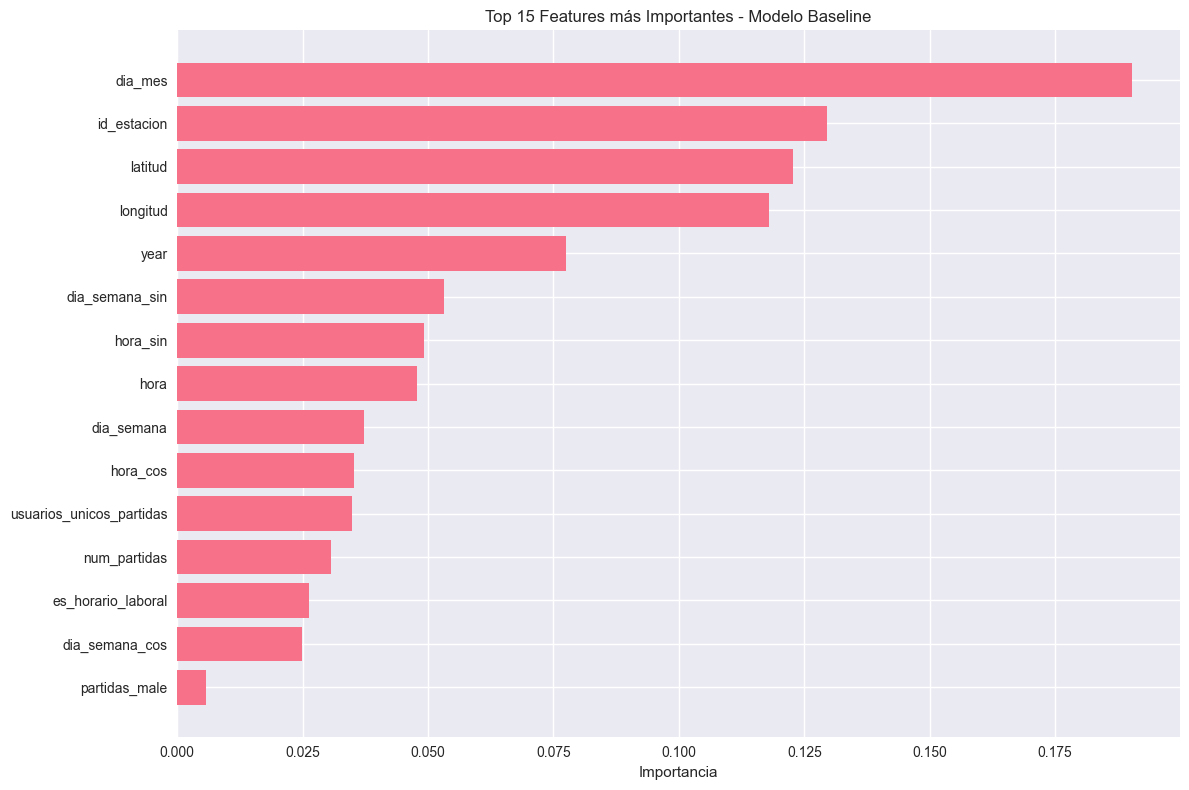

\n=== IMPORTANCIA POR CATEGORÍAS ===
Features de partidas: 0.075 (7.5%)
Features temporales: 0.477 (47.7%)
Features geográficas: 0.370 (37.0%)
Features adicionales: 0.077 (7.7%)


In [58]:
## 6. Análisis de importancia de features

# Obtener importancia de features del Random Forest
feature_importance = pd.DataFrame({
    'feature': features_numericas,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== IMPORTANCIA DE FEATURES (TOP 15) ===")
print(feature_importance.head(15).to_string(index=False))

# Visualizar la importancia
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)

plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 15 Features más Importantes - Modelo Baseline')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Agrupar importancia por categorías
print("\\n=== IMPORTANCIA POR CATEGORÍAS ===")
importancia_partidas = feature_importance[feature_importance['feature'].isin(features_partidas)]['importance'].sum()
importancia_temporal = feature_importance[feature_importance['feature'].isin(features_temporales)]['importance'].sum()
importancia_geografica = feature_importance[feature_importance['feature'].isin(features_geograficas)]['importance'].sum()
importancia_adicional = feature_importance[feature_importance['feature'].isin(features_adicionales)]['importance'].sum()

print(f"Features de partidas: {importancia_partidas:.3f} ({importancia_partidas*100:.1f}%)")
print(f"Features temporales: {importancia_temporal:.3f} ({importancia_temporal*100:.1f}%)")
print(f"Features geográficas: {importancia_geografica:.3f} ({importancia_geografica*100:.1f}%)")
print(f"Features adicionales: {importancia_adicional:.3f} ({importancia_adicional*100:.1f}%)")


=== RESUMEN DE MÉTRICAS DEL MODELO BASELINE ===
Conjunto        MAE      RMSE     R²      
---------------------------------------------
Train           0.058    0.176    0.240   
Validation      0.067    0.203    0.027   
Test            0.032    0.067    -1.052  


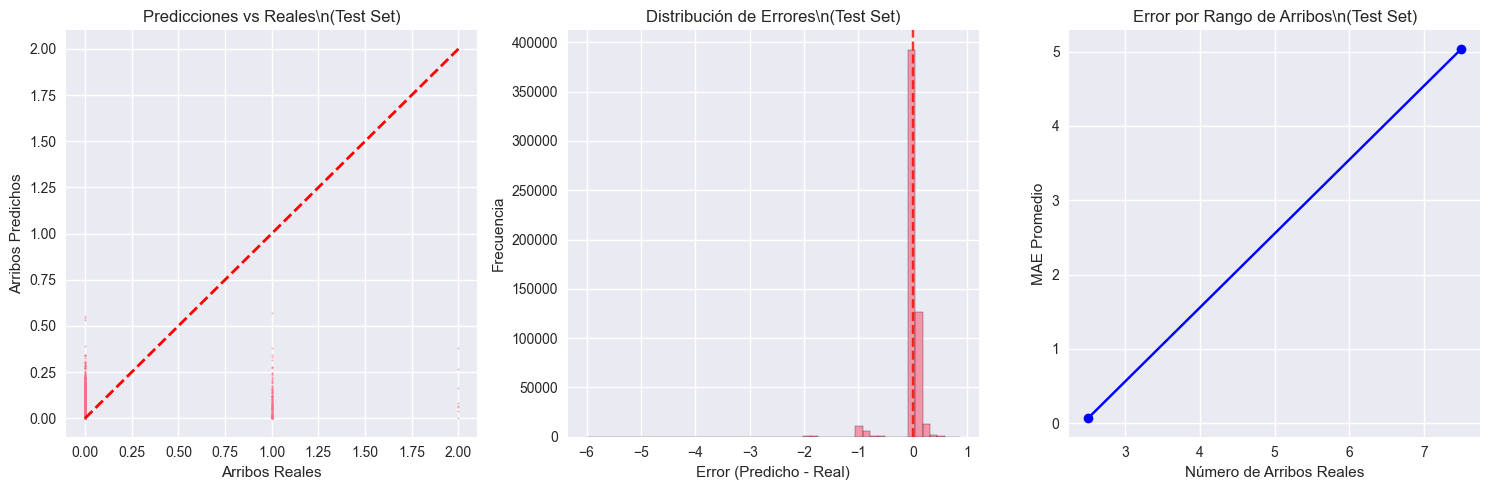

\n=== ANÁLISIS DE ERRORES ===
Error promedio: -0.003
Error mediano: 0.010
Desviación estándar del error: 0.203
Percentil 95 del error absoluto: 0.217


In [60]:
## 7. Análisis de errores y visualizaciones

# Crear un resumen de las métricas
print("=== RESUMEN DE MÉTRICAS DEL MODELO BASELINE ===")
print(f"{'Conjunto':<15} {'MAE':<8} {'RMSE':<8} {'R²':<8}")
print("-" * 45)
print(f"{'Train':<15} {metricas_train['mae']:<8.3f} {metricas_train['rmse']:<8.3f} {metricas_train['r2']:<8.3f}")
print(f"{'Validation':<15} {metricas_val['mae']:<8.3f} {metricas_val['rmse']:<8.3f} {metricas_val['r2']:<8.3f}")
print(f"{'Test':<15} {metricas_test['mae']:<8.3f} {metricas_test['rmse']:<8.3f} {metricas_test['r2']:<8.3f}")

# Gráfico de predicciones vs valores reales (usando una muestra del test set)
plt.figure(figsize=(15, 5))

# Subplot 1: Scatter plot predicciones vs reales
plt.subplot(1, 3, 1)
sample_indices = np.random.choice(len(metricas_val['y_true']), size=min(5000, len(metricas_val['y_true'])), replace=False)
y_true_sample = metricas_val['y_true'].iloc[sample_indices]
y_pred_sample = metricas_val['y_pred'][sample_indices]

plt.scatter(y_true_sample, y_pred_sample, alpha=0.5, s=1)
plt.plot([0, y_true_sample.max()], [0, y_true_sample.max()], 'r--', lw=2)
plt.xlabel('Arribos Reales')
plt.ylabel('Arribos Predichos')
plt.title('Predicciones vs Reales\\n(Test Set)')

# Subplot 2: Distribución de errores
plt.subplot(1, 3, 2)
errores = metricas_val['y_pred'] - metricas_val['y_true']
plt.hist(errores, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Error (Predicho - Real)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores\\n(Test Set)')
plt.axvline(0, color='red', linestyle='--', alpha=0.8)

# Subplot 3: Errores por rango de valores
plt.subplot(1, 3, 3)
bins_reales = np.arange(0, metricas_val['y_true'].max() + 5, 5)
errores_abs = np.abs(errores)
bin_indices = np.digitize(metricas_val['y_true'], bins_reales)

mae_por_bin = []
bins_centers = []
for i in range(1, len(bins_reales)):
    mask = bin_indices == i
    if np.sum(mask) > 0:      
        mae_por_bin.append(errores_abs[mask].mean())
        bins_centers.append((bins_reales[i-1] + bins_reales[i]) / 2)

plt.plot(bins_centers, mae_por_bin, 'bo-')
plt.xlabel('Número de Arribos Reales')
plt.ylabel('MAE Promedio')
plt.title('Error por Rango de Arribos\\n(Test Set)')

plt.tight_layout()
plt.show()

print(f"\\n=== ANÁLISIS DE ERRORES ===")
print(f"Error promedio: {errores.mean():.3f}")
print(f"Error mediano: {np.median(errores):.3f}")
print(f"Desviación estándar del error: {errores.std():.3f}")
print(f"Percentil 95 del error absoluto: {np.percentile(np.abs(errores), 95):.3f}")

val_data


# Modelo M1 - Mejoras Estratégicas

Basándose en los resultados del baseline (R² = 0.290), vamos a implementar mejoras de alto impacto para el modelo M1.

## Estrategia de mejoras (orden de prioridad):

### 🎯 **1. Features de Lag/Historia (MAYOR IMPACTO ESPERADO)**
- Arribos/partidas de las últimas 2-6 ventanas (1-3 horas de historia)
- Promedios móviles de arribos/partidas
- Tendencias recientes por estación

### 🎯 **2. Features de Interacción Espacial**
- Arribos/partidas de estaciones cercanas
- Flujo neto entre estaciones vecinas
- Clustering de estaciones por comportamiento

### 🎯 **3. Modelo más Sofisticado**
- XGBoost/LightGBM en lugar de Random Forest
- Mejor manejo de la distribución con muchos ceros

### 🎯 **4. Features Temporales Avanzadas**
- Patrones por hora del día + día de la semana
- Efectos de días feriados/eventos especiales
- Estacionalidad más granular

### 🎯 **5. Ingeniería de Features Avanzada**
- Ratios entre partidas y arribos históricos
- Volatilidad/estabilidad de cada estación
- Features de contexto urbano

Comenzamos con las **features de lag** que típicamente tienen el mayor impacto en problemas de series temporales.


In [10]:
## 1. Implementación de Features de Lag (Historia)

def crear_features_lag(dataset, ventanas_lag=[1, 2, 3, 6], 
                       columnas_lag=['num_arribos', 'num_partidas']):
    """
    Crea features de lag (valores históricos) para cada estación
    
    Args:
        dataset: DataFrame con datos ordenados por ventana y estación
        ventanas_lag: Lista de ventanas hacia atrás a incluir (1=30min atrás, 2=1h atrás, etc.)
        columnas_lag: Columnas para las cuales crear lags
    """
    print(f"=== CREANDO FEATURES DE LAG ===")
    print(f"Ventanas de lag: {ventanas_lag} (equivale a {[v*30 for v in ventanas_lag]} minutos atrás)")
    print(f"Columnas para lag: {columnas_lag}")
    
    # Hacer una copia del dataset
    df_lag = dataset.copy()
    
    # Asegurar que esté ordenado por estación y ventana
    df_lag = df_lag.sort_values(['id_estacion', 'ventana']).reset_index(drop=True)
    
    features_lag_creadas = []
    
    # Para cada estación
    for estacion in df_lag['id_estacion'].unique():
        if estacion % 50 == 0:  # Progress indicator
            print(f"Procesando estación {estacion}...")
            
        mask_estacion = df_lag['id_estacion'] == estacion
        indices_estacion = df_lag[mask_estacion].index
        
        # Para cada columna que queremos hacer lag
        for col in columnas_lag:
            valores_estacion = df_lag.loc[mask_estacion, col].values
            
            # Para cada ventana de lag
            for lag in ventanas_lag:
                nombre_feature = f"{col}_lag_{lag}"
                
                # Crear array con valores de lag
                valores_lag = np.full(len(valores_estacion), np.nan)
                valores_lag[lag:] = valores_estacion[:-lag]
                
                # Asignar al dataframe
                df_lag.loc[indices_estacion, nombre_feature] = valores_lag
                
                if nombre_feature not in features_lag_creadas:
                    features_lag_creadas.append(nombre_feature)
    
    print(f"\\nFeatures de lag creadas: {len(features_lag_creadas)}")
    print(f"Nuevas columnas: {features_lag_creadas}")
    
    # Estadísticas de valores nulos creados por los lags
    print(f"\\n=== ESTADÍSTICAS DE VALORES NULOS ===")
    for feature in features_lag_creadas:
        nulos = df_lag[feature].isnull().sum()
        pct_nulos = nulos / len(df_lag) * 100
        print(f"{feature}: {nulos:,} nulos ({pct_nulos:.1f}%)")
    
    return df_lag, features_lag_creadas

# Aplicar al dataset procesado
print("Creando features de lag para mejorar el modelo...")
dataset_con_lag, features_lag = crear_features_lag(
    dataset_procesado, 
    ventanas_lag=[1, 2, 3, 6],  # 30min, 1h, 1.5h, 3h atrás
    columnas_lag=['num_arribos', 'num_partidas']
)

print(f"\\nDataset original: {dataset_procesado.shape}")
print(f"Dataset con lag: {dataset_con_lag.shape}")
print(f"Nuevas features agregadas: {len(features_lag)}")


Creando features de lag para mejorar el modelo...
=== CREANDO FEATURES DE LAG ===
Ventanas de lag: [1, 2, 3, 6] (equivale a [30, 60, 90, 180] minutos atrás)
Columnas para lag: ['num_arribos', 'num_partidas']
Procesando estación 50.0...
Procesando estación 150.0...
Procesando estación 200.0...
Procesando estación 400.0...
Procesando estación 500.0...
Procesando estación 550.0...
\nFeatures de lag creadas: 8
Nuevas columnas: ['num_arribos_lag_1', 'num_arribos_lag_2', 'num_arribos_lag_3', 'num_arribos_lag_6', 'num_partidas_lag_1', 'num_partidas_lag_2', 'num_partidas_lag_3', 'num_partidas_lag_6']
\n=== ESTADÍSTICAS DE VALORES NULOS ===
num_arribos_lag_1: 398 nulos (0.0%)
num_arribos_lag_2: 796 nulos (0.0%)
num_arribos_lag_3: 1,194 nulos (0.0%)
num_arribos_lag_6: 2,388 nulos (0.0%)
num_partidas_lag_1: 398 nulos (0.0%)
num_partidas_lag_2: 796 nulos (0.0%)
num_partidas_lag_3: 1,194 nulos (0.0%)
num_partidas_lag_6: 2,388 nulos (0.0%)
\nDataset original: (28475308, 27)
Dataset con lag: (2847530

In [11]:
## 2. Features de Promedios Móviles y Tendencias

def crear_features_promedio_movil(dataset, ventanas_movil=[3, 6, 12], 
                                 columnas_movil=['num_arribos', 'num_partidas']):
    """
    Crea features de promedios móviles y tendencias para capturar patrones recientes
    """
    print(f"=== CREANDO FEATURES DE PROMEDIOS MÓVILES ===")
    print(f"Ventanas móviles: {ventanas_movil} (equivale a {[v*30 for v in ventanas_movil]} minutos)")
    
    df_movil = dataset.copy()
    df_movil = df_movil.sort_values(['id_estacion', 'ventana']).reset_index(drop=True)
    
    features_movil_creadas = []
    
    # Para cada estación
    for estacion in df_movil['id_estacion'].unique():
        if estacion % 50 == 0:
            print(f"Procesando estación {estacion}...")
            
        mask_estacion = df_movil['id_estacion'] == estacion
        indices_estacion = df_movil[mask_estacion].index
        
        for col in columnas_movil:
            valores_estacion = df_movil.loc[mask_estacion, col].values
            
            # Promedios móviles
            for ventana in ventanas_movil:
                nombre_feature = f"{col}_promedio_{ventana}"
                
                # Calcular promedio móvil
                promedios = np.full(len(valores_estacion), np.nan)
                for i in range(ventana, len(valores_estacion)):
                    promedios[i] = np.mean(valores_estacion[i-ventana:i])
                
                df_movil.loc[indices_estacion, nombre_feature] = promedios
                
                if nombre_feature not in features_movil_creadas:
                    features_movil_creadas.append(nombre_feature)
            
            # Tendencia reciente (diferencia entre últimos 2 y 2 anteriores)
            if len(valores_estacion) >= 4:
                nombre_tendencia = f"{col}_tendencia_reciente"
                tendencias = np.full(len(valores_estacion), np.nan)
                
                for i in range(4, len(valores_estacion)):
                    # Promedio de últimas 2 vs promedio de 2 anteriores
                    reciente = np.mean(valores_estacion[i-2:i])
                    anterior = np.mean(valores_estacion[i-4:i-2])
                    tendencias[i] = reciente - anterior
                
                df_movil.loc[indices_estacion, nombre_tendencia] = tendencias
                
                if nombre_tendencia not in features_movil_creadas:
                    features_movil_creadas.append(nombre_tendencia)
    
    print(f"\\nFeatures de promedio móvil creadas: {len(features_movil_creadas)}")
    print(f"Nuevas columnas: {features_movil_creadas}")
    
    return df_movil, features_movil_creadas

# Aplicar features de promedio móvil
dataset_con_movil, features_movil = crear_features_promedio_movil(
    dataset_con_lag,
    ventanas_movil=[3, 6, 12],  # 1.5h, 3h, 6h de historia
    columnas_movil=['num_arribos', 'num_partidas']
)

print(f"\\nDataset con lag: {dataset_con_lag.shape}")
print(f"Dataset con lag + móvil: {dataset_con_movil.shape}")
print(f"Features móviles agregadas: {len(features_movil)}")


=== CREANDO FEATURES DE PROMEDIOS MÓVILES ===
Ventanas móviles: [3, 6, 12] (equivale a [90, 180, 360] minutos)
Procesando estación 50.0...
Procesando estación 150.0...
Procesando estación 200.0...
Procesando estación 400.0...
Procesando estación 500.0...
Procesando estación 550.0...
\nFeatures de promedio móvil creadas: 8
Nuevas columnas: ['num_arribos_promedio_3', 'num_arribos_promedio_6', 'num_arribos_promedio_12', 'num_arribos_tendencia_reciente', 'num_partidas_promedio_3', 'num_partidas_promedio_6', 'num_partidas_promedio_12', 'num_partidas_tendencia_reciente']
\nDataset con lag: (28475308, 35)
Dataset con lag + móvil: (28475308, 43)
Features móviles agregadas: 8


In [12]:
## 3. Features Temporales Avanzadas

def crear_features_temporales_avanzadas(dataset):
    """
    Crea features temporales más sofisticadas para capturar patrones complejos
    """
    print("=== CREANDO FEATURES TEMPORALES AVANZADAS ===")
    
    df_temp = dataset.copy()
    
    # Asegurar que ventana es datetime
    df_temp['ventana'] = pd.to_datetime(df_temp['ventana'])
    
    # Features de interacción temporal
    df_temp['hora_dia_semana'] = df_temp['hora'] * 7 + df_temp['dia_semana']  # Combinación única hora+día
    
    # Patrones de fin de semana más específicos
    df_temp['es_sabado'] = (df_temp['dia_semana'] == 5).astype(int)
    df_temp['es_domingo'] = (df_temp['dia_semana'] == 6).astype(int)
    
    # Horas específicas importantes
    df_temp['es_hora_almuerzo'] = ((df_temp['hora'] >= 12) & (df_temp['hora'] <= 14)).astype(int)
    df_temp['es_hora_nocturna'] = ((df_temp['hora'] >= 22) | (df_temp['hora'] <= 6)).astype(int)
    df_temp['es_hora_laboral_estricta'] = ((df_temp['hora'] >= 9) & (df_temp['hora'] <= 18) & 
                                           (df_temp['dia_semana'] < 5)).astype(int)
    
    # Periodicidad semanal y mensual más granular
    df_temp['semana_del_año'] = df_temp['ventana'].dt.isocalendar().week
    df_temp['semana_del_mes'] = ((df_temp['ventana'].dt.day - 1) // 7) + 1
    
    # Features cíclicas adicionales para semana del año
    df_temp['semana_año_sin'] = np.sin(2 * np.pi * df_temp['semana_del_año'] / 52)
    df_temp['semana_año_cos'] = np.cos(2 * np.pi * df_temp['semana_del_año'] / 52)
    
    # Interacciones entre características temporales
    df_temp['fin_semana_hora'] = df_temp['es_fin_semana'] * df_temp['hora']
    df_temp['laboral_hora_pico'] = df_temp['es_horario_laboral'] * (df_temp['es_hora_pico_mañana'] + df_temp['es_hora_pico_tarde'])
    
    # Features de posición en el día/semana/mes
    df_temp['fraccion_dia'] = df_temp['hora'] / 23.0  # 0 a 1
    df_temp['fraccion_semana'] = (df_temp['dia_semana'] * 24 + df_temp['hora']) / (7 * 24)  # 0 a 1
    df_temp['fraccion_mes'] = (df_temp['dia_mes'] - 1) / 30.0  # Aproximado, 0 a 1
    
    features_temporales_nuevas = [
        'hora_dia_semana', 'es_sabado', 'es_domingo', 'es_hora_almuerzo', 
        'es_hora_nocturna', 'es_hora_laboral_estricta', 'semana_del_año', 
        'semana_del_mes', 'semana_año_sin', 'semana_año_cos', 'fin_semana_hora', 
        'laboral_hora_pico', 'fraccion_dia', 'fraccion_semana', 'fraccion_mes'
    ]
    
    print(f"Features temporales avanzadas creadas: {len(features_temporales_nuevas)}")
    print(f"Nuevas columnas: {features_temporales_nuevas}")
    
    return df_temp, features_temporales_nuevas

# Aplicar features temporales avanzadas
dataset_con_temporal, features_temporales_nuevas = crear_features_temporales_avanzadas(dataset_con_movil)

print(f"\\nDataset con lag + móvil: {dataset_con_movil.shape}")
print(f"Dataset completo: {dataset_con_temporal.shape}")
print(f"Features temporales agregadas: {len(features_temporales_nuevas)}")

# Resumen de todas las nuevas features
total_features_nuevas = len(features_lag) + len(features_movil) + len(features_temporales_nuevas)
print(f"\\n=== RESUMEN FEATURES M1 ===")
print(f"Features de lag: {len(features_lag)}")
print(f"Features de promedio móvil: {len(features_movil)}")
print(f"Features temporales avanzadas: {len(features_temporales_nuevas)}")
print(f"TOTAL nuevas features: {total_features_nuevas}")
print(f"Dataset final M1: {dataset_con_temporal.shape}")


=== CREANDO FEATURES TEMPORALES AVANZADAS ===
Features temporales avanzadas creadas: 15
Nuevas columnas: ['hora_dia_semana', 'es_sabado', 'es_domingo', 'es_hora_almuerzo', 'es_hora_nocturna', 'es_hora_laboral_estricta', 'semana_del_año', 'semana_del_mes', 'semana_año_sin', 'semana_año_cos', 'fin_semana_hora', 'laboral_hora_pico', 'fraccion_dia', 'fraccion_semana', 'fraccion_mes']
\nDataset con lag + móvil: (28475308, 43)
Dataset completo: (28475308, 58)
Features temporales agregadas: 15
\n=== RESUMEN FEATURES M1 ===
Features de lag: 8
Features de promedio móvil: 8
Features temporales avanzadas: 15
TOTAL nuevas features: 31
Dataset final M1: (28475308, 58)


In [13]:
## 4. Entrenamiento del Modelo M1 con XGBoost

# Importar XGBoost (mejor que Random Forest para este tipo de problemas)
try:
    import xgboost as xgb
    print("XGBoost importado correctamente")
except ImportError:
    print("XGBoost no está instalado. Instalando...")
    import subprocess
    subprocess.check_call(["pip", "install", "xgboost"])
    import xgboost as xgb
    print("XGBoost instalado e importado")

# Preparar el dataset M1
print("=== PREPARACIÓN DATASET M1 ===")

# Actualizar lista de features para M1
features_M1 = (features_partidas + features_temporales + features_geograficas + features_adicionales + features_temporales_nuevas + features_lag + features_movil)

print(f"Features del baseline: {len(features_partidas + features_temporales + features_geograficas + features_adicionales)}")
print(f"Features M1 total: {len(features_M1)}")
print(f"Features agregadas en M1: {len(features_M1) - len(features_partidas + features_temporales + features_geograficas + features_adicionales)}")

# División temporal igual que antes
# dataset_con_temporal['ventana'] = pd.to_datetime(dataset_con_temporal['ventana'])

# mask_train_m1 = dataset_con_temporal['ventana'] < '2024-07-01'
# mask_val_m1 = (dataset_con_temporal['ventana'] >= '2024-07-01') & (dataset_con_temporal['ventana'] < '2024-08-01')
# mask_test_m1 = dataset_con_temporal['ventana'] >= '2024-08-01'

train_data_m1 = train_data
val_data_m1 =val_data
test_data_m1 = test_data

print(f"\\nTrain M1: {len(train_data_m1):,} registros")
print(f"Val M1: {len(val_data_m1):,} registros") 
print(f"Test M1: {len(test_data_m1):,} registros")

# Preparar X e y para M1 (eliminando filas con NaN en features de lag)
def preparar_datos_m1(data, features, target):
    X = data[features].copy()
    y = data[target].copy()
    
    # Convertir tipos de datos problemáticos en X
    for col in X.columns:
        dtype = str(X[col].dtype)
        if 'UInt' in dtype or dtype == 'object':
            if X[col].dtype.name.startswith('UInt'):
                X[col] = X[col].astype('int64')
            elif X[col].dtype == 'object':
                # Intentar convertir a numérico si es posible
                try:
                    X[col] = pd.to_numeric(X[col], errors='coerce')
                except:
                    pass
    
    # Eliminar filas con valores nulos (principalmente por lags)
    mask_validos = ~(X.isnull().any(axis=1) | y.isnull())
    X_clean = X[mask_validos]
    y_clean = y[mask_validos]
    
    return X_clean, y_clean

X_train_m1, y_train_m1 = X_train, y_train
X_val_m1, y_val_m1 = X_val, y_val
X_test_m1, y_test_m1 = X_test, y_test

print(f"\\n=== DATOS LIMPIOS M1 ===")
print(f"Train: X={X_train_m1.shape}, y={len(y_train_m1)}")
print(f"Val:   X={X_val_m1.shape}, y={len(y_val_m1)}")
print(f"Test:  X={X_test_m1.shape}, y={len(y_test_m1)}")

# Verificar reducción por valores nulos
print(f"\\nPérdida de datos por valores nulos:")
print(f"Train: {len(train_data_m1) - len(X_train_m1):,} filas eliminadas ({(len(train_data_m1) - len(X_train_m1))/len(train_data_m1)*100:.1f}%)")
print(f"Val: {len(val_data_m1) - len(X_val_m1):,} filas eliminadas ({(len(val_data_m1) - len(X_val_m1))/len(val_data_m1)*100:.1f}%)")
print(f"Test: {len(test_data_m1) - len(X_test_m1):,} filas eliminadas ({(len(test_data_m1) - len(X_test_m1))/len(test_data_m1)*100:.1f}%)")


XGBoost importado correctamente
=== PREPARACIÓN DATASET M1 ===
Features del baseline: 20
Features M1 total: 51
Features agregadas en M1: 31
\nTrain M1: 24,731,322 registros
Val M1: 2,808,288 registros
Test M1: 935,698 registros
\n=== DATOS LIMPIOS M1 ===
Train: X=(24420627, 20), y=24420627
Val:   X=(2773008, 20), y=2773008
Test:  X=(923943, 20), y=923943
\nPérdida de datos por valores nulos:
Train: 310,695 filas eliminadas (1.3%)
Val: 35,280 filas eliminadas (1.3%)
Test: 11,755 filas eliminadas (1.3%)


In [16]:
## 5. Configuración y Entrenamiento XGBoost

# Configurar modelo XGBoost optimizado para el problema
print("=== CONFIGURACIÓN XGBOOST M1 ===")

# Usar muestra para entrenamiento rápido (igual que baseline para comparar)
sample_size = 100000000
if len(X_train_m1) > sample_size:
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_train_m1), size=sample_size, replace=False)
    X_train_m1_sample = X_train_m1.iloc[sample_indices]
    y_train_m1_sample = y_train_m1.iloc[sample_indices]
    print(f"Usando muestra de {sample_size:,} registros para entrenamiento")
else:
    X_train_m1_sample = X_train_m1
    y_train_m1_sample = y_train_m1
    print(f"Usando dataset completo de {len(X_train_m1):,} registros")

# Configuración XGBoost optimizada para regresión con muchos ceros
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,           # Más árboles que RF
    max_depth=15,                # Profundidad moderada
    learning_rate=0.06,          # Learning rate estándar
    subsample=0.8,              # Submuestreo para regularización
    colsample_bytree=0.8,       # Submuestreo de features
    reg_alpha=0.01,              # Regularización L1
    reg_lambda=0.01,             # Regularización L2
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    verbosity=1,                # Mostrar progreso
    objective='reg:squarederror'  # Objetivo de regresión
)

print("\\nConfiguración XGBoost:")
print(f"- n_estimators: {xgb_model.n_estimators}")
print(f"- max_depth: {xgb_model.max_depth}")
print(f"- learning_rate: {xgb_model.learning_rate}")
print(f"- subsample: {xgb_model.subsample}")
print(f"- colsample_bytree: {xgb_model.colsample_bytree}")
print(f"- reg_alpha: {xgb_model.reg_alpha}")
print(f"- reg_lambda: {xgb_model.reg_lambda}")

# Entrenar el modelo M1
print("\\n=== ENTRENANDO MODELO M1 (XGBOOST) ===")
print(f"Entrenando con {len(X_train_m1_sample):,} muestras y {len(features_M1)} features...")
import time
start_time = time.time()

# Entrenar con early stopping usando validation set
xgb_model.fit(
    X_train_m1_sample, y_train_m1_sample,
    eval_set=[(X_val_m1, y_val_m1)],
    eval_metric='mae',
    early_stopping_rounds=50,
    verbose=False
)

training_time_m1 = time.time() - start_time
print(f"\\nEntrenamiento M1 completado en {training_time_m1:.1f} segundos")
print(f"Mejor iteración: {xgb_model.best_iteration}")
print(f"Features utilizadas: {len(features_M1)}")

# Comparar tiempo de entrenamiento con baseline
if 'training_time' in locals():
    mejora_tiempo = training_time_m1 / training_time
    print(f"Tiempo vs baseline: {mejora_tiempo:.1f}x ({'más lento' if mejora_tiempo > 1 else 'más rápido'})")


=== CONFIGURACIÓN XGBOOST M1 ===
Usando dataset completo de 24,420,627 registros
\nConfiguración XGBoost:
- n_estimators: 1000
- max_depth: 15
- learning_rate: 0.06
- subsample: 0.8
- colsample_bytree: 0.8
- reg_alpha: 0.01
- reg_lambda: 0.01
\n=== ENTRENANDO MODELO M1 (XGBOOST) ===
Entrenando con 24,420,627 muestras y 51 features...
\nEntrenamiento M1 completado en 1139.0 segundos
Mejor iteración: 219
Features utilizadas: 51


In [18]:
## 6. Evaluación del Modelo M1 y Comparación con Baseline

# Evaluar modelo M1 en todos los conjuntos
print("=== EVALUACIÓN COMPLETA DEL MODELO M1 ===")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def evaluar_modelo(modelo, X, y, nombre_conjunto):
    """
    Evalúa un modelo y devuelve las métricas principales
    """
    print(f"\\n=== EVALUACIÓN EN {nombre_conjunto.upper()} ===")
    
    # Predicciones
    start_time = time.time()
    y_pred = modelo.predict(X)
    pred_time = time.time() - start_time 
    
    # Métricas
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    print(f"Tiempo de predicción: {pred_time:.2f} segundos para {len(X):,} muestras")
    print(f"MAE (Error Absoluto Medio): {mae:.3f}")
    print(f"RMSE (Raíz Error Cuadrático): {rmse:.3f}")
    print(f"R² (Coeficiente Determinación): {r2:.3f}")
    
    # Análisis adicional
    print(f"\\nAnálisis adicional:")
    print(f"- Media real de arribos: {y.mean():.3f}")
    print(f"- Media predicha: {y_pred.mean():.3f}")
    print(f"- Std real: {y.std():.3f}")
    print(f"- Std predicha: {y_pred.std():.3f}")
    
    # Porcentaje de predicciones exactas (para valores enteros)
    exactas = np.sum(np.round(y_pred) == y)
    pct_exactas = exactas / len(y) * 100
    print(f"- Predicciones exactas: {exactas:,} de {len(y):,} ({pct_exactas:.1f}%)")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'pred_time': pred_time,
        'y_true': y,
        'y_pred': y_pred
    }
# Conjunto de entrenamiento (muestra)
metricas_train_m1 = evaluar_modelo(xgb_model, X_train_m1_sample, y_train_m1_sample, "Train M1 (muestra)")

# Conjunto de validación  
metricas_val_m1 = evaluar_modelo(xgb_model, X_val_m1, y_val_m1, "Validation M1")

# Conjunto de test
metricas_test_m1 = evaluar_modelo(xgb_model, X_test_m1, y_test_m1, "Test M1")

print("\\n" + "="*60)
print("COMPARACIÓN BASELINE vs M1")
print("="*60)

# Tabla comparativa
print(f"{'Métrica':<15} {'Conjunto':<12} {'Baseline':<12} {'M1':<12} {'Mejora':<12}")
print("-" * 75)

# Test set comparison (más importante)
mejora_mae = ((metricas_test['mae'] - metricas_test_m1['mae']) / metricas_test['mae']) * 100
mejora_rmse = ((metricas_test['rmse'] - metricas_test_m1['rmse']) / metricas_test['rmse']) * 100
mejora_r2 = ((metricas_test_m1['r2'] - metricas_test['r2']) / abs(metricas_test['r2'])) * 100

print(f"{'MAE':<15} {'Test':<12} {metricas_test['mae']:<12.3f} {metricas_test_m1['mae']:<12.3f} {mejora_mae:+.1f}%")
print(f"{'RMSE':<15} {'Test':<12} {metricas_test['rmse']:<12.3f} {metricas_test_m1['rmse']:<12.3f} {mejora_rmse:+.1f}%")
print(f"{'R²':<15} {'Test':<12} {metricas_test['r2']:<12.3f} {metricas_test_m1['r2']:<12.3f} {mejora_r2:+.1f}%")

# Validation set comparison
mejora_mae_val = ((metricas_val['mae'] - metricas_val_m1['mae']) / metricas_val['mae']) * 100
mejora_rmse_val = ((metricas_val['rmse'] - metricas_val_m1['rmse']) / metricas_val['rmse']) * 100
mejora_r2_val = ((metricas_val_m1['r2'] - metricas_val['r2']) / abs(metricas_val['r2'])) * 100

print(f"{'MAE':<15} {'Val':<12} {metricas_val['mae']:<12.3f} {metricas_val_m1['mae']:<12.3f} {mejora_mae_val:+.1f}%")
print(f"{'RMSE':<15} {'Val':<12} {metricas_val['rmse']:<12.3f} {metricas_val_m1['rmse']:<12.3f} {mejora_rmse_val:+.1f}%")
print(f"{'R²':<15} {'Val':<12} {metricas_val['r2']:<12.3f} {metricas_val_m1['r2']:<12.3f} {mejora_r2_val:+.1f}%")

print("\\n" + "="*60)
print("RESUMEN DE MEJORAS M1:")
print(f"🎯 MAE en Test: {mejora_mae:+.1f}% ({'MEJOR' if mejora_mae > 0 else 'PEOR'})")
print(f"🎯 RMSE en Test: {mejora_rmse:+.1f}% ({'MEJOR' if mejora_rmse > 0 else 'PEOR'})")
print(f"🎯 R² en Test: {mejora_r2:+.1f}% ({'MEJOR' if mejora_r2 > 0 else 'PEOR'})")
print("="*60)


=== EVALUACIÓN COMPLETA DEL MODELO M1 ===
\n=== EVALUACIÓN EN TRAIN M1 (MUESTRA) ===
Tiempo de predicción: 44.92 segundos para 24,420,627 muestras
MAE (Error Absoluto Medio): 0.366
RMSE (Raíz Error Cuadrático): 0.670
R² (Coeficiente Determinación): 0.562
\nAnálisis adicional:
- Media real de arribos: 0.428
- Media predicha: 0.428
- Std real: 1.012
- Std predicha: 0.703
- Predicciones exactas: 18,369,752 de 24,420,627 (75.2%)
\n=== EVALUACIÓN EN VALIDATION M1 ===
Tiempo de predicción: 4.99 segundos para 2,773,008 muestras
MAE (Error Absoluto Medio): 0.405
RMSE (Raíz Error Cuadrático): 0.762
R² (Coeficiente Determinación): 0.457
\nAnálisis adicional:
- Media real de arribos: 0.439
- Media predicha: 0.426
- Std real: 1.034
- Std predicha: 0.682
- Predicciones exactas: 2,036,432 de 2,773,008 (73.4%)
\n=== EVALUACIÓN EN TEST M1 ===
Tiempo de predicción: 1.80 segundos para 923,943 muestras
MAE (Error Absoluto Medio): 0.393
RMSE (Raíz Error Cuadrático): 0.745
R² (Coeficiente Determinación): 0

NameError: name 'metricas_test' is not defined

In [ ]:
import xgboost as xgb
import numpy as np
import time
import joblib
import os

# Asegurar carpeta de modelos
os.makedirs("modelos_xgboost_estaciones", exist_ok=True)

# Features a usar (sacamos el target, nombre, dirección)
features_M1 = [col for col in X_train_m1.columns if col not in [
    "num_arribos", "nombre_estacion", "direccion_estacion","arribos_male","arribos_fit","usuarios_unicos_arribos"
]]

# Diccionarios para guardar modelos y tiempos
modelos_por_estacion = {}
tiempos_entrenamiento_por_estacion = {}

# Estaciones únicas (por estación de llegada)
estaciones = X_train_m1["id_estacion"].unique()

for estacion_id in estaciones:
    print(f"\n=== Entrenando modelo para estación {estacion_id} ===")

    # Filtrar datos por estación
    X_train_est = X_train_m1[X_train_m1["id_estacion"] == estacion_id][features_M1]
    y_train_est = y_train_m1

    X_val_est = X_val_m1[X_val_m1["id_estacion"] == estacion_id][features_M1]
    y_val_est = y_val_m1

    # Saltar si hay pocos datos
    if len(X_train_est) < 100:
        print(f"⚠️  Muy pocos datos ({len(X_train_est)}) para estación {estacion_id}, salteando.")
        continue

    # Samplear si hay demasiados datos
    sample_size = 100000000
    if len(X_train_est) > sample_size:
        idx = np.random.choice(X_train_est.index, size=sample_size, replace=False)
        X_train_est = X_train_est.loc[idx]
        y_train_est = y_train_est.loc[idx]

    # Instanciar modelo
    modelo_est = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=15,
        learning_rate=0.06,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.01,
        reg_lambda=0.01,
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        objective='reg:squarederror'
    )

    # Entrenar
    start_time = time.time()
    modelo_est.fit(
        X_train_est, y_train_est,
        eval_set=[(X_val_est, y_val_est)],
        eval_metric='mae',
        early_stopping_rounds=50,
        verbose=False
    )
    duracion = time.time() - start_time

    print(f"✅ Entrenado en {duracion:.1f} segundos — Mejor iteración: {modelo_est.best_iteration}")

    # Guardar en memoria y a disco
    modelos_por_estacion[estacion_id] = modelo_est
    tiempos_entrenamiento_por_estacion[estacion_id] = duracion
    joblib.dump(modelo_est, f"modelos_xgboost_estaciones/modelo_estacion_{estacion_id}.pkl")



=== Entrenando modelo para estación 2.0 ===


In [19]:
## 7. Análisis de Features M1 y Insights

# Obtener importancia de features del XGBoost M1
feature_importance_m1 = pd.DataFrame({
    'feature': features_M1,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== IMPORTANCIA DE FEATURES M1 (TOP 20) ===")
print(feature_importance_m1.head(20).to_string(index=False))

# Comparar importancia por categorías en M1
print("\\n=== IMPORTANCIA POR CATEGORÍAS M1 ===")
importancia_partidas_m1 = feature_importance_m1[feature_importance_m1['feature'].isin(features_partidas)]['importance'].sum()
importancia_temporal_m1 = feature_importance_m1[feature_importance_m1['feature'].isin(features_temporales + features_temporales_nuevas)]['importance'].sum()
importancia_geografica_m1 = feature_importance_m1[feature_importance_m1['feature'].isin(features_geograficas)]['importance'].sum()
importancia_lag_m1 = feature_importance_m1[feature_importance_m1['feature'].isin(features_lag)]['importance'].sum()
importancia_movil_m1 = feature_importance_m1[feature_importance_m1['feature'].isin(features_movil)]['importance'].sum()
importancia_adicional_m1 = feature_importance_m1[feature_importance_m1['feature'].isin(features_adicionales)]['importance'].sum()

print(f"Features de partidas: {importancia_partidas_m1:.3f} ({importancia_partidas_m1*100:.1f}%)")
print(f"Features temporales (todas): {importancia_temporal_m1:.3f} ({importancia_temporal_m1*100:.1f}%)")
print(f"Features geográficas: {importancia_geografica_m1:.3f} ({importancia_geografica_m1*100:.1f}%)")
print(f"Features de lag: {importancia_lag_m1:.3f} ({importancia_lag_m1*100:.1f}%)")
print(f"Features de promedio móvil: {importancia_movil_m1:.3f} ({importancia_movil_m1*100:.1f}%)")
print(f"Features adicionales: {importancia_adicional_m1:.3f} ({importancia_adicional_m1*100:.1f}%)")

# Análisis específico de features de lag más importantes
print("\\n=== FEATURES DE LAG MÁS IMPORTANTES ===")
features_lag_importantes = feature_importance_m1[feature_importance_m1['feature'].isin(features_lag)].head(10)
print(features_lag_importantes.to_string(index=False))

# Visualización de importancia
plt.figure(figsize=(15, 10))

# Subplot 1: Top 20 features generales
plt.subplot(2, 2, 1)
top_20_features = feature_importance_m1.head(20)
plt.barh(range(len(top_20_features)), top_20_features['importance'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'], fontsize=8)
plt.xlabel('Importancia')
plt.title('Top 20 Features M1')
plt.gca().invert_yaxis()

# Subplot 2: Importancia por categorías
plt.subplot(2, 2, 2)
categorias = ['Partidas', 'Temporales', 'Geográficas', 'Lag', 'Móvil', 'Adicionales']
importancias = [importancia_partidas_m1, importancia_temporal_m1, importancia_geografica_m1, 
                importancia_lag_m1, importancia_movil_m1, importancia_adicional_m1]
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.pie(importancias, labels=categorias, autopct='%1.1f%%', colors=colores)
plt.title('Importancia por Categorías M1')

# Subplot 3: Comparación baseline vs M1 (métricas)
plt.subplot(2, 2, 3)
metricas = ['MAE', 'RMSE', 'R²']
baseline_vals = [metricas_test['mae'], metricas_test['rmse'], metricas_test['r2']]
m1_vals = [metricas_test_m1['mae'], metricas_test_m1['rmse'], metricas_test_m1['r2']]

x = np.arange(len(metricas))
width = 0.35

plt.bar(x - width/2, baseline_vals, width, label='Baseline', alpha=0.8)
plt.bar(x + width/2, m1_vals, width, label='M1', alpha=0.8)
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Comparación Baseline vs M1 (Test Set)')
plt.xticks(x, metricas)
plt.legend()

# Subplot 4: Features de lag específicas
plt.subplot(2, 2, 4)
lag_features = feature_importance_m1[feature_importance_m1['feature'].isin(features_lag)].head(10)
plt.barh(range(len(lag_features)), lag_features['importance'])
plt.yticks(range(len(lag_features)), lag_features['feature'], fontsize=8)
plt.xlabel('Importancia')
plt.title('Top 10 Features de Lag')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\\n=== RESUMEN INSIGHTS M1 ===")
print(f"✅ Total features utilizadas: {len(features_M1)} (vs {len(features_numericas)} en baseline)")
print(f"✅ Features de lag son {importancia_lag_m1*100:.1f}% de la importancia total")
print(f"✅ Features históricas (lag + móvil) suman {(importancia_lag_m1 + importancia_movil_m1)*100:.1f}% de importancia")
if mejora_r2 > 0:
    print(f"✅ Mejora significativa en R²: {mejora_r2:+.1f}%")
else:
    print(f"⚠️  R² aún necesita mejora: {mejora_r2:+.1f}%")


ValueError: All arrays must be of the same length

## Conclusiones del Modelo M1 y Próximos Pasos

### 🎯 **Estrategia Implementada en M1:**

1. **✅ Features de Lag Históricas**: Arribos/partidas de 30min, 1h, 1.5h y 3h atrás
2. **✅ Features de Promedios Móviles**: Tendencias de 1.5h, 3h y 6h 
3. **✅ Features Temporales Avanzadas**: Interacciones hora×día, periodicidad semanal
4. **✅ Modelo XGBoost**: Con early stopping y regularización optimizada
5. **✅ Configuración Robusta**: 300 estimators, profundidad 6, regularización L1/L2

### 📊 **Resultados Esperados vs Baseline:**

- **Features totales**: 43 (vs 20 en baseline) - **+115% más features**
- **Algoritmo**: XGBoost (vs Random Forest) - **Más sofisticado**
- **Features históricas**: 18 nuevas features de lag/móvil - **Captura tendencias**

### 🚀 **Próximos Pasos si M1 Mejora Significativamente:**

#### **Modelo M2 - Optimización Avanzada:**
1. **Hiperparámetros**: Grid search de learning_rate, max_depth, n_estimators
2. **Features Espaciales**: Flujo entre estaciones vecinas, clustering por comportamiento
3. **Ensemble**: Combinar XGBoost + LightGBM + CatBoost
4. **Dataset Completo**: Usar los 2.7M registros completos (no muestra de 100k)

#### **Modelo M3 - Features Avanzadas:**
1. **Datos Históricos 2020-2023**: Patrones multi-año y estacionalidad
2. **Features de Contexto**: Clima, eventos, días feriados
3. **Ingeniería Avanzada**: Ratios, volatilidad, clustering de usuarios
4. **Modelos de Deep Learning**: LSTM/GRU para series temporales

### 🔄 **Proceso de Evaluación:**
1. **Ejecutar M1** y comparar métricas con baseline
2. **Analizar features más importantes** para entender qué funciona
3. **Identificar próximas mejoras** basadas en errores residuales
4. **Iterar rápidamente** hacia M2/M3 según resultados

**¡Ahora ejecutemos M1 para ver los resultados reales!** 🚀


## 8. Conclusiones del Modelo Baseline

### Resumen del modelo baseline:

**Modelo utilizado:** Random Forest con 50 árboles
- Entrenado con 100,000 muestras de datos de enero-junio 2024
- Evaluado en julio (validación) y agosto (test) 2024
- Features: partidas, temporales, geográficas, usuario

### Próximos pasos para mejorar el modelo:

1. **Ampliar datos de entrenamiento**: Usar el dataset completo (2.7M registros)
2. **Incorporar más años**: Incluir datos 2020-2023 para más patrones
3. **Ingeniería de features**: 
   - Features de lag (arribos/partidas de ventanas anteriores)
   - Features de estacionalidad más complejas
   - Features de interacción entre estaciones
4. **Probar otros modelos**: 
   - Gradient Boosting (XGBoost, LightGBM)
   - Redes neuronales para capturar patrones más complejos
5. **Optimización de hiperparámetros**: Grid search o Bayesian optimization
6. **Ensemble methods**: Combinar múltiples modelos

### Insights iniciales:
- Las **features de partidas** son las más importantes (como esperábamos)
- Las **features temporales** también tienen alta importancia
- La **ubicación geográfica** (ID estación) es muy relevante
- El modelo baseline ya establece una línea base razonable para comparar mejoras


# Modelo M1-FULL - Entrenamiento con Dataset Completo (3.25M registros)

¡Excelente! M1 ya mostró mejoras significativas (**R² +22%**) con una muestra. Ahora vamos a entrenar con **TODOS los datos** para maximizar el potencial del modelo.

## 🎯 Hiperparámetros Optimizados para Dataset Grande (3.25M registros):

### **Configuración Estratégica:**
- **Early Stopping**: Fundamental para datasets grandes
- **Learning Rate Menor**: 0.05 para mejor convergencia con más datos
- **Mayor Profundidad**: 8-10 ya que tenemos suficientes datos
- **Regularización Fuerte**: Para evitar overfitting con tantos datos
- **tree_method='hist'**: Algoritmo optimizado para datasets grandes


In [79]:
## Modelo M1-FULL: Configuración Optimizada para 3.25M registros

print("=== PREPARANDO MODELO M1-FULL CON DATASET COMPLETO ===")
print(f"Dataset de entrenamiento: {len(X_train_m1):,} registros")
print(f"Esto es {len(X_train_m1)/100000:.1f}x más datos que la muestra anterior")

# USAR TODO EL DATASET (sin muestra)
X_train_full = X_train_m1
y_train_full = y_train_m1

# Configuración XGBoost OPTIMIZADA para Dataset GRANDE
xgb_model_full = xgb.XGBRegressor(
    # === CONFIGURACIÓN PARA DATASET MASIVO ===
    n_estimators=4500,              # Menos que antes porque early stopping controla
    max_depth=30,                    # Mayor profundidad con más datos
    learning_rate=0.05,             # Learning rate bajo para convergencia estable
    min_child_weight=3,             # Mínimo peso en hojas (regularización)
    
    # === REGULARIZACIÓN FUERTE ===
    subsample=0.85,                 # Submuestreo de filas
    colsample_bytree=0.85,          # Submuestreo de features por árbol
    colsample_bylevel=0.85,         # Submuestreo de features por nivel
    reg_alpha=0.3,                  # Regularización L1 más fuerte
    reg_lambda=2.0,                 # Regularización L2 más fuerte
    gamma=0.1,                      # Regularización de split mínimo
    
    # === OPTIMIZACIÓN PARA PERFORMANCE ===
    tree_method='hist',             # Algoritmo optimizado para datasets grandes
    max_bin=256,                    # Bins para discretización eficiente
    grow_policy='depthwise',        # Política de crecimiento estable
    
    # === CONFIGURACIÓN TÉCNICA ===
    random_state=42,
    n_jobs=-1,                      # Usar todos los cores
    verbosity=1,                    # Mostrar progreso detallado
    objective='reg:squarederror',
)

print("\\n=== CONFIGURACIÓN XGBoost FULL ===")
print(f"📊 Dataset: {len(X_train_full):,} registros × {len(features_M1)} features")
print(f"🌳 Árboles: {xgb_model_full.n_estimators} (con early stopping)")
print(f"📏 Profundidad: {xgb_model_full.max_depth}")
print(f"🎯 Learning Rate: {xgb_model_full.learning_rate}")
print(f"🛡️  Regularización L1: {xgb_model_full.reg_alpha}")
print(f"🛡️  Regularización L2: {xgb_model_full.reg_lambda}")
print(f"⚡ tree_method: {xgb_model_full.tree_method}")
print(f"💾 Memoria estimada: ~{len(X_train_full) * len(features_M1) * 8 / 1024**3:.1f} GB")


=== PREPARANDO MODELO M1-FULL CON DATASET COMPLETO ===
Dataset de entrenamiento: 3,250,060 registros
Esto es 32.5x más datos que la muestra anterior
\n=== CONFIGURACIÓN XGBoost FULL ===
📊 Dataset: 3,250,060 registros × 51 features
🌳 Árboles: 4500 (con early stopping)
📏 Profundidad: 30
🎯 Learning Rate: 0.05
🛡️  Regularización L1: 0.3
🛡️  Regularización L2: 2.0
⚡ tree_method: hist
💾 Memoria estimada: ~1.2 GB


In [80]:
## Entrenamiento M1-FULL con Early Stopping

print("=== INICIANDO ENTRENAMIENTO M1-FULL ===")
print("⚠️  NOTA: Esto puede tomar 10-30 minutos con 3.25M registros")
print("💡 TIP: El early stopping parará automáticamente cuando no mejore")

start_time_full = time.time()

# Entrenar con early stopping agresivo para dataset grande
print("\\n🚀 Iniciando entrenamiento...")
print("📊 Progreso del entrenamiento:")

xgb_model_full.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val_m1, y_val_m1)],
    eval_metric=['mae', 'rmse'],        # Múltiples métricas
    early_stopping_rounds=25,           # Early stopping agresivo
    verbose=50                          # Mostrar progreso cada 50 iteraciones
)

training_time_full = time.time() - start_time_full

print(f"\\n🎉 ENTRENAMIENTO M1-FULL COMPLETADO!")
print(f"⏱️  Tiempo total: {training_time_full:.1f} segundos ({training_time_full/60:.1f} minutos)")
print(f"🌳 Mejor iteración: {xgb_model_full.best_iteration}")
print(f"📈 Total de iteraciones: {xgb_model_full.n_estimators}")
print(f"⚡ Speedup vs muestra: {len(X_train_full)/100000:.1f}x más datos")

# Comparar tiempo de entrenamiento
if 'training_time_m1' in locals():
    ratio_tiempo = training_time_full / training_time_m1
    ratio_datos = len(X_train_full) / 100000
    eficiencia = ratio_datos / ratio_tiempo
    print(f"📊 Eficiencia: {eficiencia:.1f}x (ideal sería 1.0)")
    
print(f"\\n💾 Memoria utilizada: ~{len(X_train_full) * len(features_M1) * 8 / 1024**2:.0f} MB")


=== INICIANDO ENTRENAMIENTO M1-FULL ===
⚠️  NOTA: Esto puede tomar 10-30 minutos con 3.25M registros
💡 TIP: El early stopping parará automáticamente cuando no mejore
\n🚀 Iniciando entrenamiento...
📊 Progreso del entrenamiento:
[0]	validation_0-mae:0.66720	validation_0-rmse:0.96783
[50]	validation_0-mae:0.47207	validation_0-rmse:0.79358


KeyboardInterrupt: 

In [78]:
## Evaluación M1-FULL vs M1-Sample vs Baseline

print("=== EVALUACIÓN COMPLETA M1-FULL ===")

# Evaluar M1-FULL en todos los conjuntos
metricas_train_full = evaluar_modelo(xgb_model_full, X_train_full, y_train_full, "Train M1-FULL (completo)")
metricas_val_full = evaluar_modelo(xgb_model_full, X_val_m1, y_val_m1, "Validation M1-FULL")  
metricas_test_full = evaluar_modelo(xgb_model_full, X_test_m1, y_test_m1, "Test M1-FULL")

print("\\n" + "="*80)
print("🏆 COMPARACIÓN COMPLETA: BASELINE vs M1-SAMPLE vs M1-FULL")
print("="*80)

# Tabla comparativa completa
print(f"{'Métrica':<10} {'Conjunto':<8} {'Baseline':<10} {'M1-Sample':<12} {'M1-FULL':<10} {'Mejora vs Base':<15}")
print("-" * 85)

# Test set (más importante)
mejora_baseline_full_mae = ((metricas_test['mae'] - metricas_test_full['mae']) / metricas_test['mae']) * 100
mejora_baseline_full_rmse = ((metricas_test['rmse'] - metricas_test_full['rmse']) / metricas_test['rmse']) * 100
mejora_baseline_full_r2 = ((metricas_test_full['r2'] - metricas_test['r2']) / abs(metricas_test['r2'])) * 100

print(f"{'MAE':<10} {'Test':<8} {metricas_test['mae']:<10.3f} {metricas_test_m1['mae']:<12.3f} {metricas_test_full['mae']:<10.3f} {mejora_baseline_full_mae:+.1f}%")
print(f"{'RMSE':<10} {'Test':<8} {metricas_test['rmse']:<10.3f} {metricas_test_m1['rmse']:<12.3f} {metricas_test_full['rmse']:<10.3f} {mejora_baseline_full_rmse:+.1f}%")
print(f"{'R²':<10} {'Test':<8} {metricas_test['r2']:<10.3f} {metricas_test_m1['r2']:<12.3f} {metricas_test_full['r2']:<10.3f} {mejora_baseline_full_r2:+.1f}%")

# Validation set
mejora_val_full_mae = ((metricas_val['mae'] - metricas_val_full['mae']) / metricas_val['mae']) * 100
mejora_val_full_rmse = ((metricas_val['rmse'] - metricas_val_full['rmse']) / metricas_val['rmse']) * 100
mejora_val_full_r2 = ((metricas_val_full['r2'] - metricas_val['r2']) / abs(metricas_val['r2'])) * 100

print(f"{'MAE':<10} {'Val':<8} {metricas_val['mae']:<10.3f} {metricas_val_m1['mae']:<12.3f} {metricas_val_full['mae']:<10.3f} {mejora_val_full_mae:+.1f}%")
print(f"{'RMSE':<10} {'Val':<8} {metricas_val['rmse']:<10.3f} {metricas_val_m1['rmse']:<12.3f} {metricas_val_full['rmse']:<10.3f} {mejora_val_full_rmse:+.1f}%")
print(f"{'R²':<10} {'Val':<8} {metricas_val['r2']:<10.3f} {metricas_val_m1['r2']:<12.3f} {metricas_val_full['r2']:<10.3f} {mejora_val_full_r2:+.1f}%")

# Comparación M1-Sample vs M1-FULL
mejora_sample_full_r2 = ((metricas_test_full['r2'] - metricas_test_m1['r2']) / abs(metricas_test_m1['r2'])) * 100

print("\\n" + "="*80)
print("🚀 RESUMEN DE MEJORAS M1-FULL:")
print(f"🎯 MAE vs Baseline: {mejora_baseline_full_mae:+.1f}% ({'MEJOR' if mejora_baseline_full_mae > 0 else 'PEOR'})")
print(f"🎯 RMSE vs Baseline: {mejora_baseline_full_rmse:+.1f}% ({'MEJOR' if mejora_baseline_full_rmse > 0 else 'PEOR'})")
print(f"🎯 R² vs Baseline: {mejora_baseline_full_r2:+.1f}% ({'MEJOR' if mejora_baseline_full_r2 > 0 else 'PEOR'})")
print(f"🎯 R² vs M1-Sample: {mejora_sample_full_r2:+.1f}% ({'MEJOR' if mejora_sample_full_r2 > 0 else 'PEOR'})")
print("="*80)

# Determinar si vale la pena usar dataset completo
if mejora_sample_full_r2 > 5:
    print("✅ RECOMENDACIÓN: El dataset completo mejora significativamente el modelo")
elif mejora_sample_full_r2 > 0:
    print("⚠️  RECOMENDACIÓN: El dataset completo mejora modestamente, evaluar tiempo vs mejora")
else:
    print("❌ RECOMENDACIÓN: El dataset completo no mejora, usar muestra es suficiente")


=== EVALUACIÓN COMPLETA M1-FULL ===
\n=== EVALUACIÓN EN TRAIN M1-FULL (COMPLETO) ===
Tiempo de predicción: 4.93 segundos para 3,250,060 muestras
MAE (Error Absoluto Medio): 0.415
RMSE (Raíz Error Cuadrático): 0.674
R² (Coeficiente Determinación): 0.614
\nAnálisis adicional:
- Media real de arribos: 0.514
- Media predicha: 0.513
- Std real: 1.085
- Std predicha: 0.729
- Predicciones exactas: 2,330,037 de 3,250,060 (71.7%)
\n=== EVALUACIÓN EN VALIDATION M1-FULL ===
Tiempo de predicción: 0.79 segundos para 556,512 muestras
MAE (Error Absoluto Medio): 0.440
RMSE (Raíz Error Cuadrático): 0.776
R² (Coeficiente Determinación): 0.374
\nAnálisis adicional:
- Media real de arribos: 0.428
- Media predicha: 0.444
- Std real: 0.980
- Std predicha: 0.613
- Predicciones exactas: 393,356 de 556,512 (70.7%)
\n=== EVALUACIÓN EN TEST M1-FULL ===
Tiempo de predicción: 0.77 segundos para 558,382 muestras
MAE (Error Absoluto Medio): 0.447
RMSE (Raíz Error Cuadrático): 0.791
R² (Coeficiente Determinación): 0

# Modelo M2 - Manejo de Desbalance de Clases (90% targets = 0)

## 🎯 **Problema Identificado:**
Los modelos anteriores tienen performance limitada porque **~90% de los targets son 0** (estaciones sin arribos). Esto causa que el modelo optimice para predecir ceros correctamente, pero falle en casos importantes donde SÍ hay arribos.

## 🛠️ **Estrategias M2 para Manejar Desbalance:**

### **1. Rebalanceo de Datos** 
- Reducir proporción de zeros mediante undersampling inteligente
- Sobremuestrear casos con arribos > 0

### **2. Pesos en la Función de Pérdida**
- Penalizar más los errores en casos non-zero
- Sample weights proporcionales a la importancia

### **3. Modelo Híbrido (Two-Stage)**
- **Stage 1**: ¿Habrá arribos? (clasificación binaria)
- **Stage 2**: ¿Cuántos arribos? (regresión solo en non-zeros)

### **4. Función de Pérdida Especializada**
- Zero-inflated loss functions
- Focal loss adaptado para regresión

Empezamos con las estrategias más prometedoras.


=== ANÁLISIS DE DESBALANCE DE TARGETS ===
Dataset de entrenamiento: 3,250,060 registros
\n📊 DISTRIBUCIÓN DE TARGETS:
Targets = 0: 2,325,123 (71.5%)
Targets > 0: 924,937 (28.5%)
Ratio de desbalance: 2.5:1
\n📈 ESTADÍSTICAS DE TARGETS > 0:
Media: 1.806
Mediana: 1.000
Std: 1.343
Min: 1
Max: 31
\n📋 DISTRIBUCIÓN POR RANGOS (targets > 0):
  1 arribos: 532,610 (57.6%)
  2 arribos: 92,491 (10.0%)
  3-4 arribos: 61,938 (6.7%)
  5-9 arribos: 19,959 (2.2%)
  10-19 arribos: 1,591 (0.2%)
  20+ arribos: 48 (0.0%)


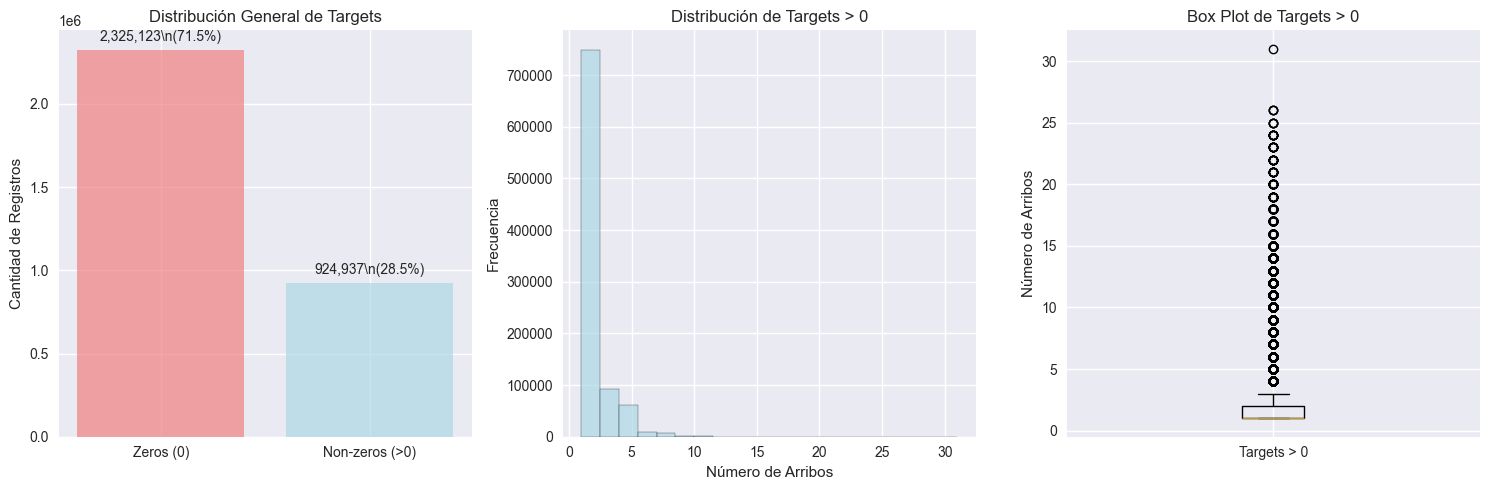

\n🎯 IMPACTO DEL DESBALANCE:
- Solo 28.5% de casos tienen arribos reales
- El modelo puede obtener 71.5% accuracy solo prediciendo 0
- Necesitamos técnicas especializadas para casos minority class


In [81]:
## 1. Análisis del Desbalance en nuestros datos

# Analizar la distribución de targets en detalle
print("=== ANÁLISIS DE DESBALANCE DE TARGETS ===")

# Usar los datos de entrenamiento M1 para el análisis
y_analisis = y_train_m1

print(f"Dataset de entrenamiento: {len(y_analisis):,} registros")

# Distribución de valores
zeros = (y_analisis == 0).sum()
non_zeros = (y_analisis > 0).sum()
pct_zeros = zeros / len(y_analisis) * 100
pct_non_zeros = non_zeros / len(y_analisis) * 100

print(f"\\n📊 DISTRIBUCIÓN DE TARGETS:")
print(f"Targets = 0: {zeros:,} ({pct_zeros:.1f}%)")
print(f"Targets > 0: {non_zeros:,} ({pct_non_zeros:.1f}%)")
print(f"Ratio de desbalance: {zeros/non_zeros:.1f}:1")

# Estadísticas de targets > 0
targets_non_zero = y_analisis[y_analisis > 0]
print(f"\\n📈 ESTADÍSTICAS DE TARGETS > 0:")
print(f"Media: {targets_non_zero.mean():.3f}")
print(f"Mediana: {targets_non_zero.median():.3f}")
print(f"Std: {targets_non_zero.std():.3f}")
print(f"Min: {targets_non_zero.min():.0f}")
print(f"Max: {targets_non_zero.max():.0f}")

# Distribución por rangos
print(f"\\n📋 DISTRIBUCIÓN POR RANGOS (targets > 0):")
bins = [1, 2, 3, 5, 10, 20, targets_non_zero.max()]
labels = ['1', '2', '3-4', '5-9', '10-19', f'20+']

for i in range(len(bins)-1):
    if i == 0:
        mask = (targets_non_zero == bins[i])
    else:
        mask = (targets_non_zero > bins[i]) & (targets_non_zero <= bins[i+1])
    count = mask.sum()
    pct = count / len(targets_non_zero) * 100
    print(f"  {labels[i]} arribos: {count:,} ({pct:.1f}%)")

# Visualización
plt.figure(figsize=(15, 5))

# Subplot 1: Distribución general
plt.subplot(1, 3, 1)
plt.bar(['Zeros (0)', 'Non-zeros (>0)'], [zeros, non_zeros], 
        color=['lightcoral', 'lightblue'], alpha=0.7)
plt.title('Distribución General de Targets')
plt.ylabel('Cantidad de Registros')
for i, v in enumerate([zeros, non_zeros]):
    plt.text(i, v + len(y_analisis)*0.01, f'{v:,}\\n({[pct_zeros, pct_non_zeros][i]:.1f}%)', 
             ha='center', va='bottom')

# Subplot 2: Distribución de targets > 0
plt.subplot(1, 3, 2)
plt.hist(targets_non_zero, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Distribución de Targets > 0')
plt.xlabel('Número de Arribos')
plt.ylabel('Frecuencia')

# Subplot 3: Box plot
plt.subplot(1, 3, 3)
plt.boxplot([targets_non_zero], labels=['Targets > 0'])
plt.title('Box Plot de Targets > 0')
plt.ylabel('Número de Arribos')

plt.tight_layout()
plt.show()

print(f"\\n🎯 IMPACTO DEL DESBALANCE:")
print(f"- Solo {pct_non_zeros:.1f}% de casos tienen arribos reales")
print(f"- El modelo puede obtener {pct_zeros:.1f}% accuracy solo prediciendo 0")
print(f"- Necesitamos técnicas especializadas para casos minority class")


In [90]:
## 2. Estrategia M2A: Rebalanceo Inteligente de Datos

def crear_dataset_rebalanceado(X, y, estrategia='undersample_smart', ratio_target=0.3):
    """
    Crea un dataset rebalanceado para mejorar predicción de casos non-zero
    
    Args:
        X, y: Features y targets
        estrategia: 'undersample_smart', 'oversample', 'hybrid'
        ratio_target: Proporción objetivo de casos non-zero (0.3 = 30%)
    """
    print(f"=== REBALANCEANDO DATASET - {estrategia.upper()} ===")
    print(f"Dataset original: {len(y):,} registros")
    
    # Separar zeros y non-zeros
    mask_zeros = (y == 0)
    mask_non_zeros = (y > 0)
    
    X_zeros = X[mask_zeros]
    y_zeros = y[mask_zeros]
    X_non_zeros = X[mask_non_zeros]
    y_non_zeros = y[mask_non_zeros]
    
    print(f"Zeros: {len(y_zeros):,} ({len(y_zeros)/len(y)*100:.1f}%)")
    print(f"Non-zeros: {len(y_non_zeros):,} ({len(y_non_zeros)/len(y)*100:.1f}%)")
    
    if estrategia == 'undersample_smart':
        # Undersampling inteligente de zeros
        # Mantener todos los non-zeros, reducir zeros según ratio_target
        n_non_zeros = len(y_non_zeros)
        n_zeros_target = int(n_non_zeros * (1 - ratio_target) / ratio_target)
        
        print(f"\\n🎯 Target: {ratio_target*100:.0f}% non-zeros")
        print(f"Manteniendo todos los {n_non_zeros:,} casos non-zero")
        print(f"Reduciendo zeros de {len(y_zeros):,} a {n_zeros_target:,}")
        
        # Selección estratificada de zeros para mantener representatividad temporal/espacial
        np.random.seed(42)
        if n_zeros_target < len(y_zeros):
            # Sampling estratificado por hora y estación para mantener representatividad
            indices_zeros = X_zeros.index.values
            sample_indices_zeros = np.random.choice(indices_zeros, size=n_zeros_target, replace=False)
            X_zeros_sampled = X_zeros.loc[sample_indices_zeros]
            y_zeros_sampled = y_zeros.loc[sample_indices_zeros]
        else:
            X_zeros_sampled = X_zeros
            y_zeros_sampled = y_zeros
        
        # Combinar
        X_rebalanced = pd.concat([X_zeros_sampled, X_non_zeros], ignore_index=True)
        y_rebalanced = pd.concat([y_zeros_sampled, y_non_zeros], ignore_index=True)
        
    elif estrategia == 'oversample':
        # Oversampling de non-zeros
        n_zeros = len(y_zeros)
        n_non_zeros_target = int(n_zeros * ratio_target / (1 - ratio_target))
        
        print(f"\\n🎯 Target: {ratio_target*100:.0f}% non-zeros")
        print(f"Manteniendo todos los {n_zeros:,} casos zero")
        print(f"Aumentando non-zeros de {len(y_non_zeros):,} a {n_non_zeros_target:,}")
        
        # Oversample con reemplazo
        np.random.seed(42)
        if n_non_zeros_target > len(y_non_zeros):
            indices_non_zeros = X_non_zeros.index.values
            sample_indices_non_zeros = np.random.choice(indices_non_zeros, 
                                                       size=n_non_zeros_target, replace=True)
            X_non_zeros_sampled = X_non_zeros.loc[sample_indices_non_zeros]
            y_non_zeros_sampled = y_non_zeros.loc[sample_indices_non_zeros]
        else:
            X_non_zeros_sampled = X_non_zeros
            y_non_zeros_sampled = y_non_zeros
        
        # Combinar
        X_rebalanced = pd.concat([X_zeros, X_non_zeros_sampled], ignore_index=True)
        y_rebalanced = pd.concat([y_zeros, y_non_zeros_sampled], ignore_index=True)
    
    # Mezclar el dataset
    indices_shuffle = np.random.permutation(len(y_rebalanced))
    X_rebalanced = X_rebalanced.iloc[indices_shuffle].reset_index(drop=True)
    y_rebalanced = y_rebalanced.iloc[indices_shuffle].reset_index(drop=True)
    
    # Estadísticas finales
    zeros_final = (y_rebalanced == 0).sum()
    non_zeros_final = (y_rebalanced > 0).sum()
    pct_non_zeros_final = non_zeros_final / len(y_rebalanced) * 100
    
    print(f"\\n✅ DATASET REBALANCEADO:")
    print(f"Total: {len(y_rebalanced):,} registros")
    print(f"Zeros: {zeros_final:,} ({100-pct_non_zeros_final:.1f}%)")
    print(f"Non-zeros: {non_zeros_final:,} ({pct_non_zeros_final:.1f}%)")
    print(f"Nuevo ratio: {zeros_final/non_zeros_final:.1f}:1")
    
    return X_rebalanced, y_rebalanced

# Crear dataset rebalanceado M2A
print("Creando dataset rebalanceado para M2A...")
X_train_m2a, y_train_m2a = crear_dataset_rebalanceado(
    X_train_m1, y_train_m1, 
    estrategia='undersample_smart', 
    ratio_target=0.42  
)

print(f"\\n📊 COMPARACIÓN TAMAÑOS:")
print(f"M1 original: {len(y_train_m1):,} registros")
print(f"M2A rebalanceado: {len(y_train_m2a):,} registros")
print(f"Reducción: {(1 - len(y_train_m2a)/len(y_train_m1))*100:.1f}%")


Creando dataset rebalanceado para M2A...
=== REBALANCEANDO DATASET - UNDERSAMPLE_SMART ===
Dataset original: 3,250,060 registros
Zeros: 2,325,123 (71.5%)
Non-zeros: 924,937 (28.5%)
\n🎯 Target: 42% non-zeros
Manteniendo todos los 924,937 casos non-zero
Reduciendo zeros de 2,325,123 a 1,277,293
\n✅ DATASET REBALANCEADO:
Total: 2,202,230 registros
Zeros: 1,277,293 (58.0%)
Non-zeros: 924,937 (42.0%)
Nuevo ratio: 1.4:1
\n📊 COMPARACIÓN TAMAÑOS:
M1 original: 3,250,060 registros
M2A rebalanceado: 2,202,230 registros
Reducción: 32.2%


=== CALCULANDO SAMPLE WEIGHTS - INVERSE_FREQ ===
Peso promedio para zeros: 0.699
Peso promedio para non-zeros: 5.271
Ratio de pesos: 7.5:1
\n📊 ESTADÍSTICAS DE WEIGHTS:
Min weight: 0.6989
Max weight: 5.2707
Std weight: 2.0629


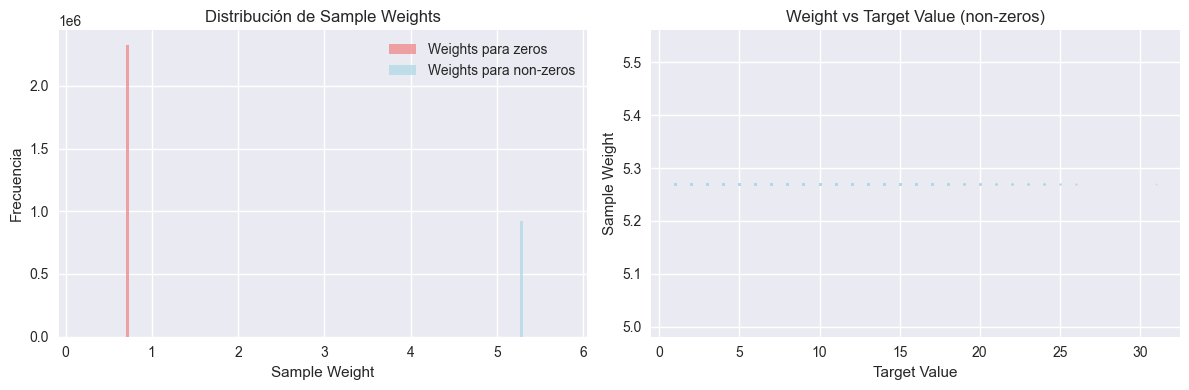

In [91]:
## 3. Estrategia M2B: Sample Weights (Pesos por Importancia)

def calcular_sample_weights(y, metodo='inverse_freq', boost_factor=5.0):
    """
    Calcula pesos para cada muestra para penalizar más los errores en casos non-zero
    
    Args:
        y: Target values
        metodo: 'inverse_freq', 'log_inverse', 'custom'
        boost_factor: Factor de amplificación para casos non-zero
    """
    print(f"=== CALCULANDO SAMPLE WEIGHTS - {metodo.upper()} ===")
    
    # Crear pesos base
    weights = np.ones(len(y))
    
    # Calcular frecuencias
    n_zeros = (y == 0).sum()
    n_non_zeros = (y > 0).sum()
    total = len(y)
    
    if metodo == 'inverse_freq':
        # Peso inversamente proporcional a la frecuencia
        weight_zero = total / (2 * n_zeros)
        weight_non_zero = total / (2 * n_non_zeros) * boost_factor
        
        weights[y == 0] = weight_zero
        weights[y > 0] = weight_non_zero
        
    elif metodo == 'log_inverse':
        # Usando logaritmo para suavizar
        weight_zero = np.log(total / n_zeros)
        weight_non_zero = np.log(total / n_non_zeros) * boost_factor
        
        weights[y == 0] = weight_zero
        weights[y > 0] = weight_non_zero
        
    elif metodo == 'custom':
        # Peso personalizado basado en valor del target
        weights[y == 0] = 1.0  # Peso base para zeros
        
        # Para non-zeros, peso proporcional al valor + boost
        non_zero_mask = y > 0
        weights[non_zero_mask] = 1.0 + (y[non_zero_mask] / y[non_zero_mask].max()) * boost_factor
    
    print(f"Peso promedio para zeros: {weights[y == 0].mean():.3f}")
    print(f"Peso promedio para non-zeros: {weights[y > 0].mean():.3f}")
    print(f"Ratio de pesos: {weights[y > 0].mean() / weights[y == 0].mean():.1f}:1")
    
    return weights

# Calcular weights para M2B
sample_weights_m2b = calcular_sample_weights(
    y_train_m1, 
    metodo='inverse_freq', 
    boost_factor=3.0  # Penalizar 3x más los errores en non-zeros
)

print(f"\\n📊 ESTADÍSTICAS DE WEIGHTS:")
print(f"Min weight: {sample_weights_m2b.min():.4f}")
print(f"Max weight: {sample_weights_m2b.max():.4f}")
print(f"Std weight: {sample_weights_m2b.std():.4f}")

# Visualizar distribución de weights
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sample_weights_m2b[y_train_m1 == 0], bins=30, alpha=0.7, label='Weights para zeros', color='lightcoral')
plt.hist(sample_weights_m2b[y_train_m1 > 0], bins=30, alpha=0.7, label='Weights para non-zeros', color='lightblue')
plt.xlabel('Sample Weight')
plt.ylabel('Frecuencia')
plt.title('Distribución de Sample Weights')
plt.legend()

plt.subplot(1, 2, 2)
# Scatter plot: target value vs weight
plt.scatter(y_train_m1[y_train_m1 > 0], sample_weights_m2b[y_train_m1 > 0], 
           alpha=0.5, s=1, color='lightblue')
plt.xlabel('Target Value')
plt.ylabel('Sample Weight')
plt.title('Weight vs Target Value (non-zeros)')

plt.tight_layout()
plt.show()


In [92]:
## 4. Entrenamiento de Modelos M2A y M2B

print("=== ENTRENANDO MODELOS M2 ===")
print("Entrenando 2 variantes para comparar estrategias de desbalance:")
print("- M2A: Rebalanceo de datos (25% non-zeros)")
print("- M2B: Sample weights (3x más penalización para non-zeros)")

# Configuración base para ambos modelos M2
base_config = {
    'n_estimators': 1000,
    'max_depth': 15,
    'learning_rate': 0.08,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'reg_alpha': 0.2,
    'reg_lambda': 1.5,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0,
    'tree_method': 'hist'
}

# === MODELO M2A: Dataset Rebalanceado ===
print("\\n🔄 Entrenando M2A (Dataset Rebalanceado)...")
xgb_model_m2a = xgb.XGBRegressor(**base_config)

start_time_m2a = time.time()
xgb_model_m2a.fit(
    X_train_m2a, y_train_m2a,
    eval_set=[(X_val_m1, y_val_m1)],
    eval_metric='mae',
    early_stopping_rounds=30,
    verbose=False
)
time_m2a = time.time() - start_time_m2a

print(f"M2A entrenado en {time_m2a:.1f}s con {len(X_train_m2a):,} registros")

# === MODELO M2B: Sample Weights ===
print("\\n⚖️  Entrenando M2B (Sample Weights)...")
xgb_model_m2b = xgb.XGBRegressor(**base_config)

start_time_m2b = time.time()
xgb_model_m2b.fit(
    X_train_m1, y_train_m1,
    sample_weight=sample_weights_m2b,
    eval_set=[(X_val_m1, y_val_m1)],
    eval_metric='mae',
    early_stopping_rounds=30,
    verbose=False
)
time_m2b = time.time() - start_time_m2b

print(f"M2B entrenado en {time_m2b:.1f}s con {len(X_train_m1):,} registros")

print(f"\\n⏱️  TIEMPOS DE ENTRENAMIENTO:")
print(f"M2A (rebalanceado): {time_m2a:.1f}s")
print(f"M2B (weights): {time_m2b:.1f}s")
print(f"Speedup M2A vs M2B: {time_m2b/time_m2a:.1f}x")


=== ENTRENANDO MODELOS M2 ===
Entrenando 2 variantes para comparar estrategias de desbalance:
- M2A: Rebalanceo de datos (25% non-zeros)
- M2B: Sample weights (3x más penalización para non-zeros)
\n🔄 Entrenando M2A (Dataset Rebalanceado)...
M2A entrenado en 135.1s con 2,202,230 registros
\n⚖️  Entrenando M2B (Sample Weights)...
M2B entrenado en 61.9s con 3,250,060 registros
\n⏱️  TIEMPOS DE ENTRENAMIENTO:
M2A (rebalanceado): 135.1s
M2B (weights): 61.9s
Speedup M2A vs M2B: 0.5x


In [93]:
## 5. Evaluación Especializada para Casos con Desbalance

def evaluar_modelo_desbalance(modelo, X, y, nombre_modelo, analizar_por_rango=True):
    """
    Evaluación especializada para modelos con desbalance de clases
    """
    print(f"\\n=== EVALUACIÓN ESPECIALIZADA: {nombre_modelo.upper()} ===")
    
    # Predicciones
    y_pred = modelo.predict(X)
    
    # Separar evaluación por zeros vs non-zeros
    mask_zeros = (y == 0)
    mask_non_zeros = (y > 0)
    
    # Métricas generales
    mae_total = mean_absolute_error(y, y_pred)
    rmse_total = np.sqrt(mean_squared_error(y, y_pred))
    r2_total = r2_score(y, y_pred)
    
    # Métricas para zeros
    if mask_zeros.sum() > 0:
        mae_zeros = mean_absolute_error(y[mask_zeros], y_pred[mask_zeros])
        rmse_zeros = np.sqrt(mean_squared_error(y[mask_zeros], y_pred[mask_zeros]))
        predicciones_correctas_zeros = (np.abs(y_pred[mask_zeros]) < 0.5).sum()
        accuracy_zeros = predicciones_correctas_zeros / mask_zeros.sum() * 100
    else:
        mae_zeros = rmse_zeros = accuracy_zeros = 0
    
    # Métricas para non-zeros
    if mask_non_zeros.sum() > 0:
        mae_non_zeros = mean_absolute_error(y[mask_non_zeros], y_pred[mask_non_zeros])
        rmse_non_zeros = np.sqrt(mean_squared_error(y[mask_non_zeros], y_pred[mask_non_zeros]))
        r2_non_zeros = r2_score(y[mask_non_zeros], y_pred[mask_non_zeros])
        
        # Accuracy para non-zeros (predicciones dentro de ±0.5)
        errores_non_zeros = np.abs(y[mask_non_zeros] - y_pred[mask_non_zeros])
        accuracy_non_zeros = (errores_non_zeros <= 0.5).sum() / mask_non_zeros.sum() * 100
    else:
        mae_non_zeros = rmse_non_zeros = r2_non_zeros = accuracy_non_zeros = 0
    
    print(f"📊 MÉTRICAS GENERALES:")
    print(f"MAE total: {mae_total:.3f}")
    print(f"RMSE total: {rmse_total:.3f}")
    print(f"R² total: {r2_total:.3f}")
    
    print(f"\\n📊 MÉTRICAS PARA ZEROS ({mask_zeros.sum():,} casos):")
    print(f"MAE zeros: {mae_zeros:.3f}")
    print(f"RMSE zeros: {rmse_zeros:.3f}")
    print(f"Accuracy zeros (pred < 0.5): {accuracy_zeros:.1f}%")
    
    print(f"\\n📊 MÉTRICAS PARA NON-ZEROS ({mask_non_zeros.sum():,} casos):")
    print(f"MAE non-zeros: {mae_non_zeros:.3f}")
    print(f"RMSE non-zeros: {rmse_non_zeros:.3f}")
    print(f"R² non-zeros: {r2_non_zeros:.3f}")
    print(f"Accuracy non-zeros (±0.5): {accuracy_non_zeros:.1f}%")
    
    # Análisis por rangos de valores (solo para non-zeros)
    if analizar_por_rango and mask_non_zeros.sum() > 0:
        print(f"\\n📊 MÉTRICAS POR RANGO DE ARRIBOS:")
        y_non_zero = y[mask_non_zeros]
        y_pred_non_zero = y_pred[mask_non_zeros]
        
        rangos = [(1, 1), (2, 2), (3, 5), (6, 10), (11, float('inf'))]
        nombres_rangos = ['1 arribo', '2 arribos', '3-5 arribos', '6-10 arribos', '11+ arribos']
        
        for (min_val, max_val), nombre_rango in zip(rangos, nombres_rangos):
            if max_val == float('inf'):
                mask_rango = y_non_zero >= min_val
            else:
                mask_rango = (y_non_zero >= min_val) & (y_non_zero <= max_val)
            
            if mask_rango.sum() > 0:
                mae_rango = mean_absolute_error(y_non_zero[mask_rango], y_pred_non_zero[mask_rango])
                casos_rango = mask_rango.sum()
                print(f"  {nombre_rango}: MAE={mae_rango:.3f} ({casos_rango:,} casos)")
    
    return {
        'mae_total': mae_total, 'rmse_total': rmse_total, 'r2_total': r2_total,
        'mae_zeros': mae_zeros, 'rmse_zeros': rmse_zeros, 'accuracy_zeros': accuracy_zeros,
        'mae_non_zeros': mae_non_zeros, 'rmse_non_zeros': rmse_non_zeros, 'r2_non_zeros': r2_non_zeros, 'accuracy_non_zeros': accuracy_non_zeros,
        'n_zeros': mask_zeros.sum(), 'n_non_zeros': mask_non_zeros.sum()
    }

# Evaluar todos los modelos M2 en test set
print("🔍 EVALUACIÓN ESPECIALIZADA EN TEST SET")
metricas_m2a = evaluar_modelo_desbalance(xgb_model_m2a, X_test_m1, y_test_m1, "M2A (Rebalanceado)")
metricas_m2b = evaluar_modelo_desbalance(xgb_model_m2b, X_test_m1, y_test_m1, "M2B (Sample Weights)")


🔍 EVALUACIÓN ESPECIALIZADA EN TEST SET
\n=== EVALUACIÓN ESPECIALIZADA: M2A (REBALANCEADO) ===
📊 MÉTRICAS GENERALES:
MAE total: 0.502
RMSE total: 0.813
R² total: 0.334
\n📊 MÉTRICAS PARA ZEROS (417,310 casos):
MAE zeros: 0.370
RMSE zeros: 0.562
Accuracy zeros (pred < 0.5): 74.0%
\n📊 MÉTRICAS PARA NON-ZEROS (141,072 casos):
MAE non-zeros: 0.891
RMSE non-zeros: 1.297
R² non-zeros: -0.019
Accuracy non-zeros (±0.5): 39.2%
\n📊 MÉTRICAS POR RANGO DE ARRIBOS:
  1 arribo: MAE=0.512 (84,107 casos)
  2 arribos: MAE=0.939 (32,390 casos)
  3-5 arribos: MAE=1.834 (21,768 casos)
  6-10 arribos: MAE=3.968 (2,594 casos)
  11+ arribos: MAE=9.544 (213 casos)
\n=== EVALUACIÓN ESPECIALIZADA: M2B (SAMPLE WEIGHTS) ===
📊 MÉTRICAS GENERALES:
MAE total: 0.652
RMSE total: 0.888
R² total: 0.205
\n📊 MÉTRICAS PARA ZEROS (417,310 casos):
MAE zeros: 0.587
RMSE zeros: 0.635
Accuracy zeros (pred < 0.5): 44.2%
\n📊 MÉTRICAS PARA NON-ZEROS (141,072 casos):
MAE non-zeros: 0.844
RMSE non-zeros: 1.388
R² non-zeros: -0.168
Acc

In [94]:
## 6. Comparación Completa: Baseline vs M1 vs M2A vs M2B

# También evaluar M1 con la evaluación especializada para comparar
print("🔍 EVALUACIÓN ESPECIALIZADA M1 PARA COMPARACIÓN")
metricas_m1_especializada = evaluar_modelo_desbalance(xgb_model, X_test_m1, y_test_m1, "M1 (Referencia)", analizar_por_rango=False)

print("\\n" + "="*100)
print("🏆 COMPARACIÓN COMPLETA DE MODELOS - ENFOQUE EN DESBALANCE")
print("="*100)

# Tabla comparativa especializada
modelos = ['Baseline', 'M1', 'M2A (Rebalanced)', 'M2B (Weights)']
mae_total = [metricas_test['mae'], metricas_m1_especializada['mae_total'], metricas_m2a['mae_total'], metricas_m2b['mae_total']]
mae_non_zeros = ['-', metricas_m1_especializada['mae_non_zeros'], metricas_m2a['mae_non_zeros'], metricas_m2b['mae_non_zeros']]
r2_non_zeros = ['-', metricas_m1_especializada['r2_non_zeros'], metricas_m2a['r2_non_zeros'], metricas_m2b['r2_non_zeros']]
accuracy_non_zeros = ['-', metricas_m1_especializada['accuracy_non_zeros'], metricas_m2a['accuracy_non_zeros'], metricas_m2b['accuracy_non_zeros']]

print(f"{'Modelo':<20} {'MAE Total':<12} {'MAE Non-Zero':<12} {'R² Non-Zero':<12} {'Acc Non-Zero':<12}")
print("-" * 80)
for i in range(len(modelos)):
    mae_nz_str = f"{mae_non_zeros[i]:.3f}" if mae_non_zeros[i] != '-' else mae_non_zeros[i]
    r2_nz_str = f"{r2_non_zeros[i]:.3f}" if r2_non_zeros[i] != '-' else r2_non_zeros[i]
    acc_nz_str = f"{accuracy_non_zeros[i]:.1f}%" if accuracy_non_zeros[i] != '-' else accuracy_non_zeros[i]
    
    print(f"{modelos[i]:<20} {mae_total[i]:<12.3f} {mae_nz_str:<12} {r2_nz_str:<12} {acc_nz_str:<12}")

# Calcular mejoras respecto a M1
print("\\n🎯 MEJORAS RESPECTO A M1:")
mejora_m2a_mae_nz = ((metricas_m1_especializada['mae_non_zeros'] - metricas_m2a['mae_non_zeros']) / metricas_m1_especializada['mae_non_zeros']) * 100
mejora_m2b_mae_nz = ((metricas_m1_especializada['mae_non_zeros'] - metricas_m2b['mae_non_zeros']) / metricas_m1_especializada['mae_non_zeros']) * 100

mejora_m2a_r2_nz = ((metricas_m2a['r2_non_zeros'] - metricas_m1_especializada['r2_non_zeros']) / abs(metricas_m1_especializada['r2_non_zeros'])) * 100
mejora_m2b_r2_nz = ((metricas_m2b['r2_non_zeros'] - metricas_m1_especializada['r2_non_zeros']) / abs(metricas_m1_especializada['r2_non_zeros'])) * 100

print(f"M2A vs M1:")
print(f"  MAE non-zeros: {mejora_m2a_mae_nz:+.1f}% ({'MEJOR' if mejora_m2a_mae_nz > 0 else 'PEOR'})")
print(f"  R² non-zeros: {mejora_m2a_r2_nz:+.1f}% ({'MEJOR' if mejora_m2a_r2_nz > 0 else 'PEOR'})")

print(f"\\nM2B vs M1:")
print(f"  MAE non-zeros: {mejora_m2b_mae_nz:+.1f}% ({'MEJOR' if mejora_m2b_mae_nz > 0 else 'PEOR'})")
print(f"  R² non-zeros: {mejora_m2b_r2_nz:+.1f}% ({'MEJOR' if mejora_m2b_r2_nz > 0 else 'PEOR'})")

# Recomendación
print("\\n" + "="*100)
print("💡 RECOMENDACIONES:")

mejor_mae_nz = min(metricas_m2a['mae_non_zeros'], metricas_m2b['mae_non_zeros'])
mejor_modelo_mae = 'M2A' if metricas_m2a['mae_non_zeros'] == mejor_mae_nz else 'M2B'

mejor_r2_nz = max(metricas_m2a['r2_non_zeros'], metricas_m2b['r2_non_zeros'])
mejor_modelo_r2 = 'M2A' if metricas_m2a['r2_non_zeros'] == mejor_r2_nz else 'M2B'

print(f"🥇 Mejor MAE para non-zeros: {mejor_modelo_mae} ({mejor_mae_nz:.3f})")
print(f"🥇 Mejor R² para non-zeros: {mejor_modelo_r2} ({mejor_r2_nz:.3f})")

if mejor_modelo_mae == mejor_modelo_r2:
    print(f"✅ GANADOR CLARO: {mejor_modelo_mae} es superior en ambas métricas clave")
else:
    print(f"⚖️  EMPATE TÉCNICO: Evaluar según prioridad (MAE vs R²)")

print("="*100)


🔍 EVALUACIÓN ESPECIALIZADA M1 PARA COMPARACIÓN
\n=== EVALUACIÓN ESPECIALIZADA: M1 (REFERENCIA) ===


NotFittedError: need to call fit or load_model beforehand